# Imports

In [1]:
import yfinance        as yf
import seaborn         as sns
import numpy           as np
import pandas          as pd
import statsmodels.api as sm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve, mean_squared_error

from matplotlib              import pyplot as plt
from pandas_datareader       import data   as pdr
from IPython.core.display    import HTML

## Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Loading data

In [3]:
yf.pdr_override()

In [4]:
start = '2000-01-01'
#end = '2019-12-31'
end = '2021-12-31'

data = pdr.get_data_yahoo( '^GSPC', start=start, end=end )

[*********************100%***********************]  1 of 1 completed


In [5]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


In [6]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-23,4703.959961,4740.740234,4703.959961,4725.790039,4725.790039,2913040000
2021-12-27,4733.990234,4791.490234,4733.990234,4791.189941,4791.189941,2770290000
2021-12-28,4795.490234,4807.020020,4780.040039,4786.350098,4786.350098,2707920000
2021-12-29,4788.640137,4804.060059,4778.080078,4793.060059,4793.060059,2963310000
2021-12-30,4794.229980,4808.930176,4775.330078,4778.729980,4778.729980,3124950000


# Data Description

In [7]:
df2 = data.copy()

In [8]:
df2.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

# Times Series Visualization

In [9]:
df3 = df2.copy()

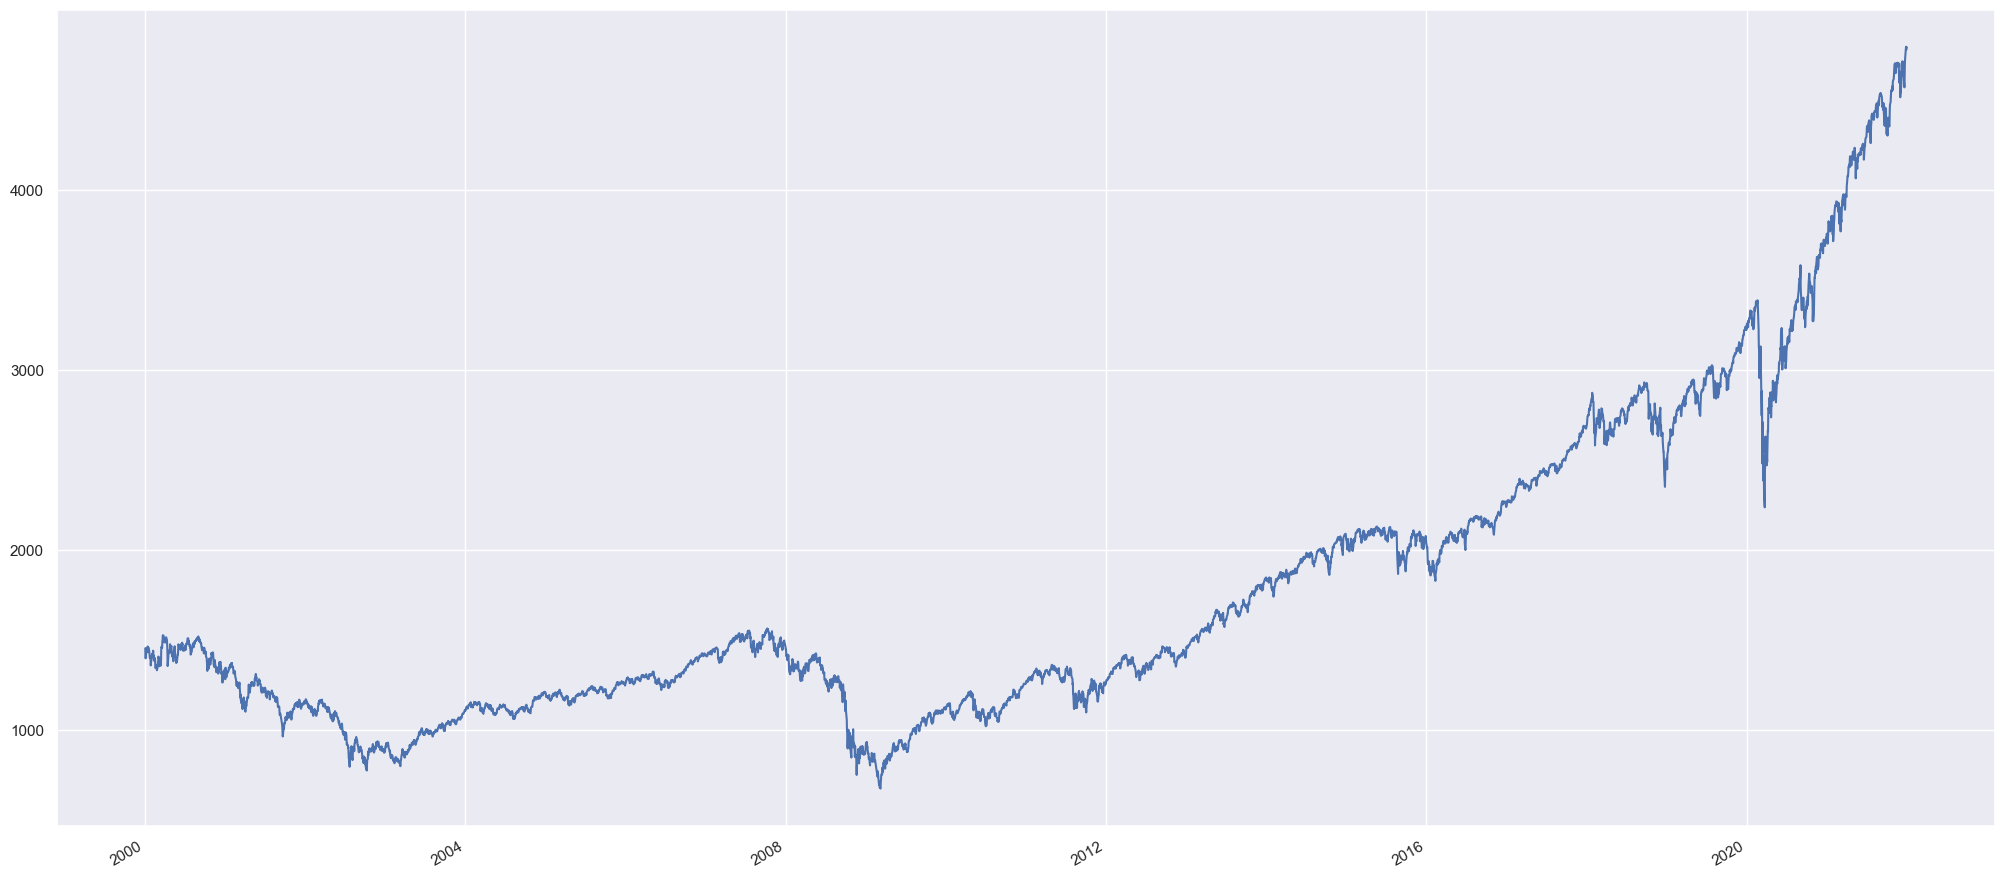

In [10]:
df3['Close'].plot()
#plt.title( 'Gráfico da Série S&P 500' );
plt.xlabel( '' );

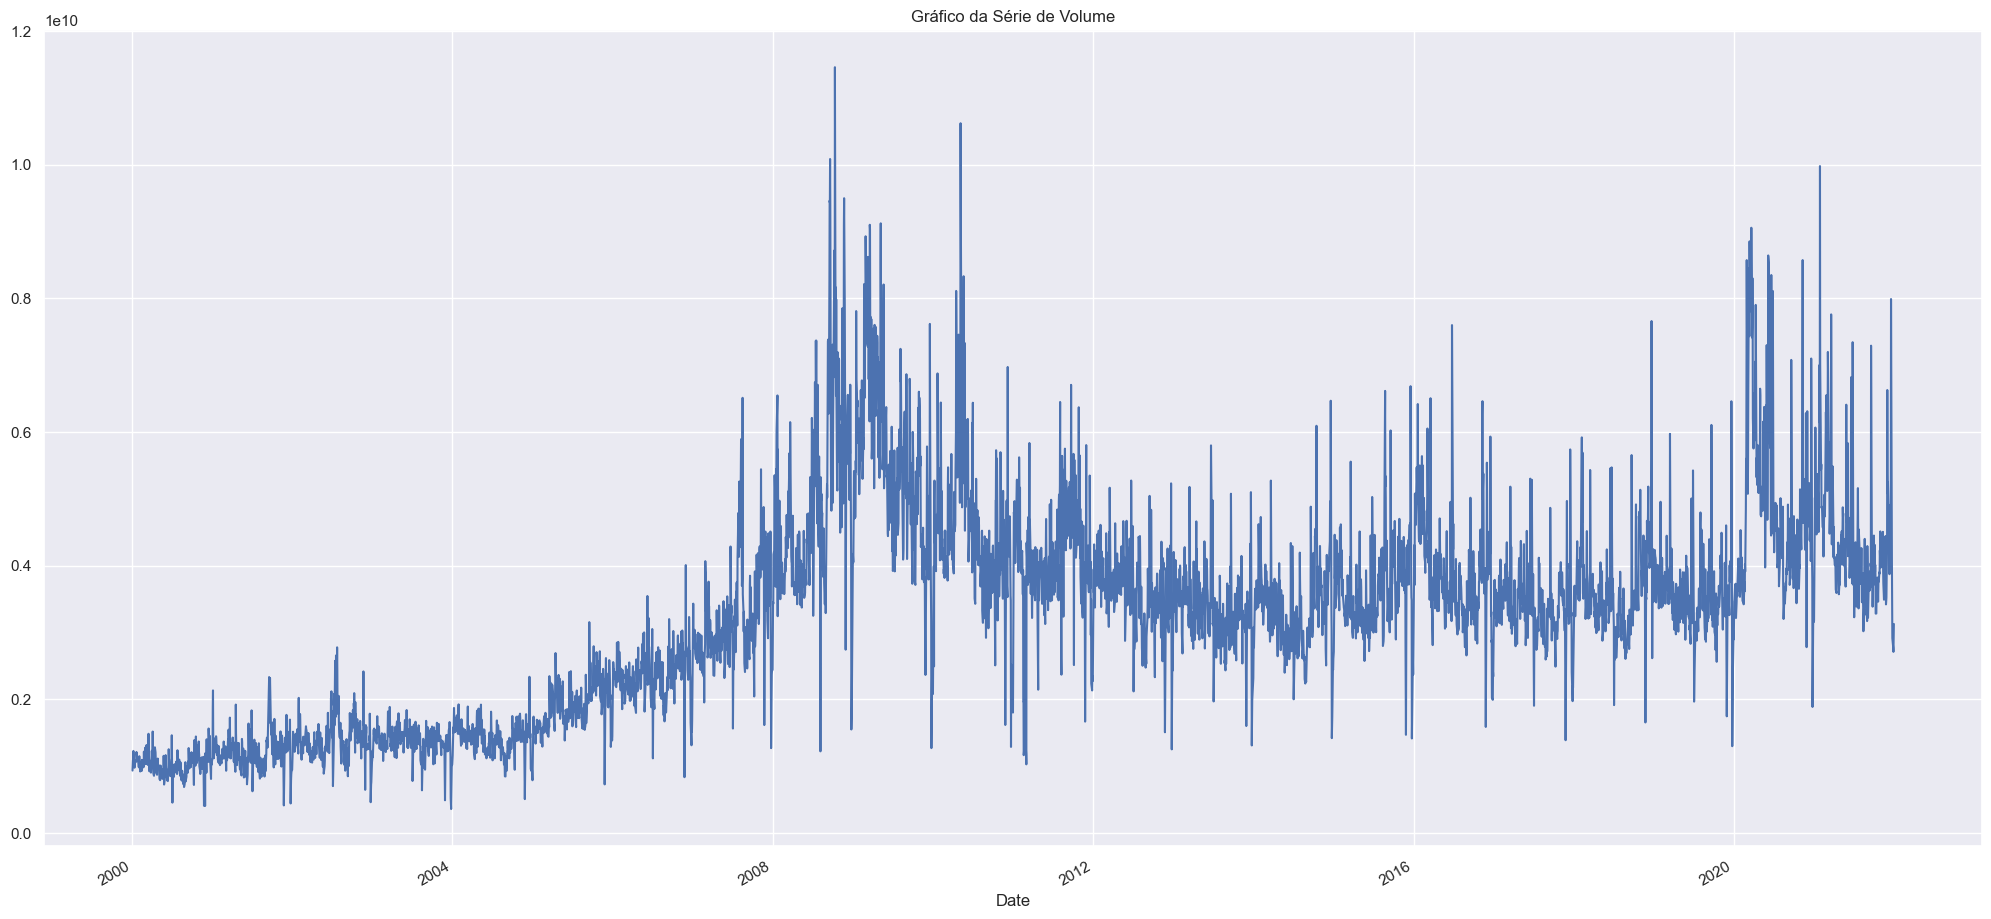

In [11]:
df3['Volume'].plot();
plt.title( 'Gráfico da Série de Volume' );

# Exploratory Data Analysis

In [12]:
df4 = df3.copy()

In [13]:
df4.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5535.000000,5535.000000,5535.000000,5535.000000,5535.000000,5.535000e+03
mean,1772.102924,1782.233612,1761.197519,1772.378729,1772.378729,3.237908e+09
std,856.734841,859.780494,853.671921,857.084851,857.084851,1.521928e+09
min,679.280029,695.270020,666.789978,676.530029,676.530029,3.560700e+08
25%,1173.785034,1182.119995,1166.144958,1173.805054,1173.805054,1.855095e+09
50%,1409.119995,1415.890015,1399.250000,1409.119995,1409.119995,3.349090e+09
75%,2123.404907,2130.660034,2115.059937,2125.030029,2125.030029,4.075415e+09
max,4795.490234,4808.930176,4780.040039,4793.060059,4793.060059,1.145623e+10


In [14]:
# lag de X periodos

periodos = 1

# lag positivo de X periodos
df4['Lag_P1'] = df4['Close'].shift( periodos )

In [15]:
df4.head()

,Open,High,Low,Close,Adj Close,Volume,Lag_P1
Date,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000,NaN
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,1455.219971
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,1399.420044
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,1402.109985
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,1403.449951


In [16]:
# Dummy para saber se o dia atual é Alta(1) ou Baixa(0)

df4['High_Low'] = np.where( df4['Close'] > df4['Lag_P1'], 1, 0 )

In [17]:
df4.head()

,Open,High,Low,Close,Adj Close,Volume,Lag_P1,High_Low
Date,,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000,NaN,0
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,1455.219971,0
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,1399.420044,1
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,1402.109985,1
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,1403.449951,1


In [18]:
df4['High_Low'].mean()

0.538572719060524

In [19]:
# Calculando o Retorno

df4['Retorno'] = df4['Close'].pct_change( periodos )

In [20]:
df4.head()

,Open,High,Low,Close,Adj Close,Volume,Lag_P1,High_Low,Retorno
Date,,,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000,NaN,0,NaN
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,1455.219971,0,-0.038345
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,1399.420044,1,0.001922
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,1402.109985,1,0.000956
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,1403.449951,1,0.027090


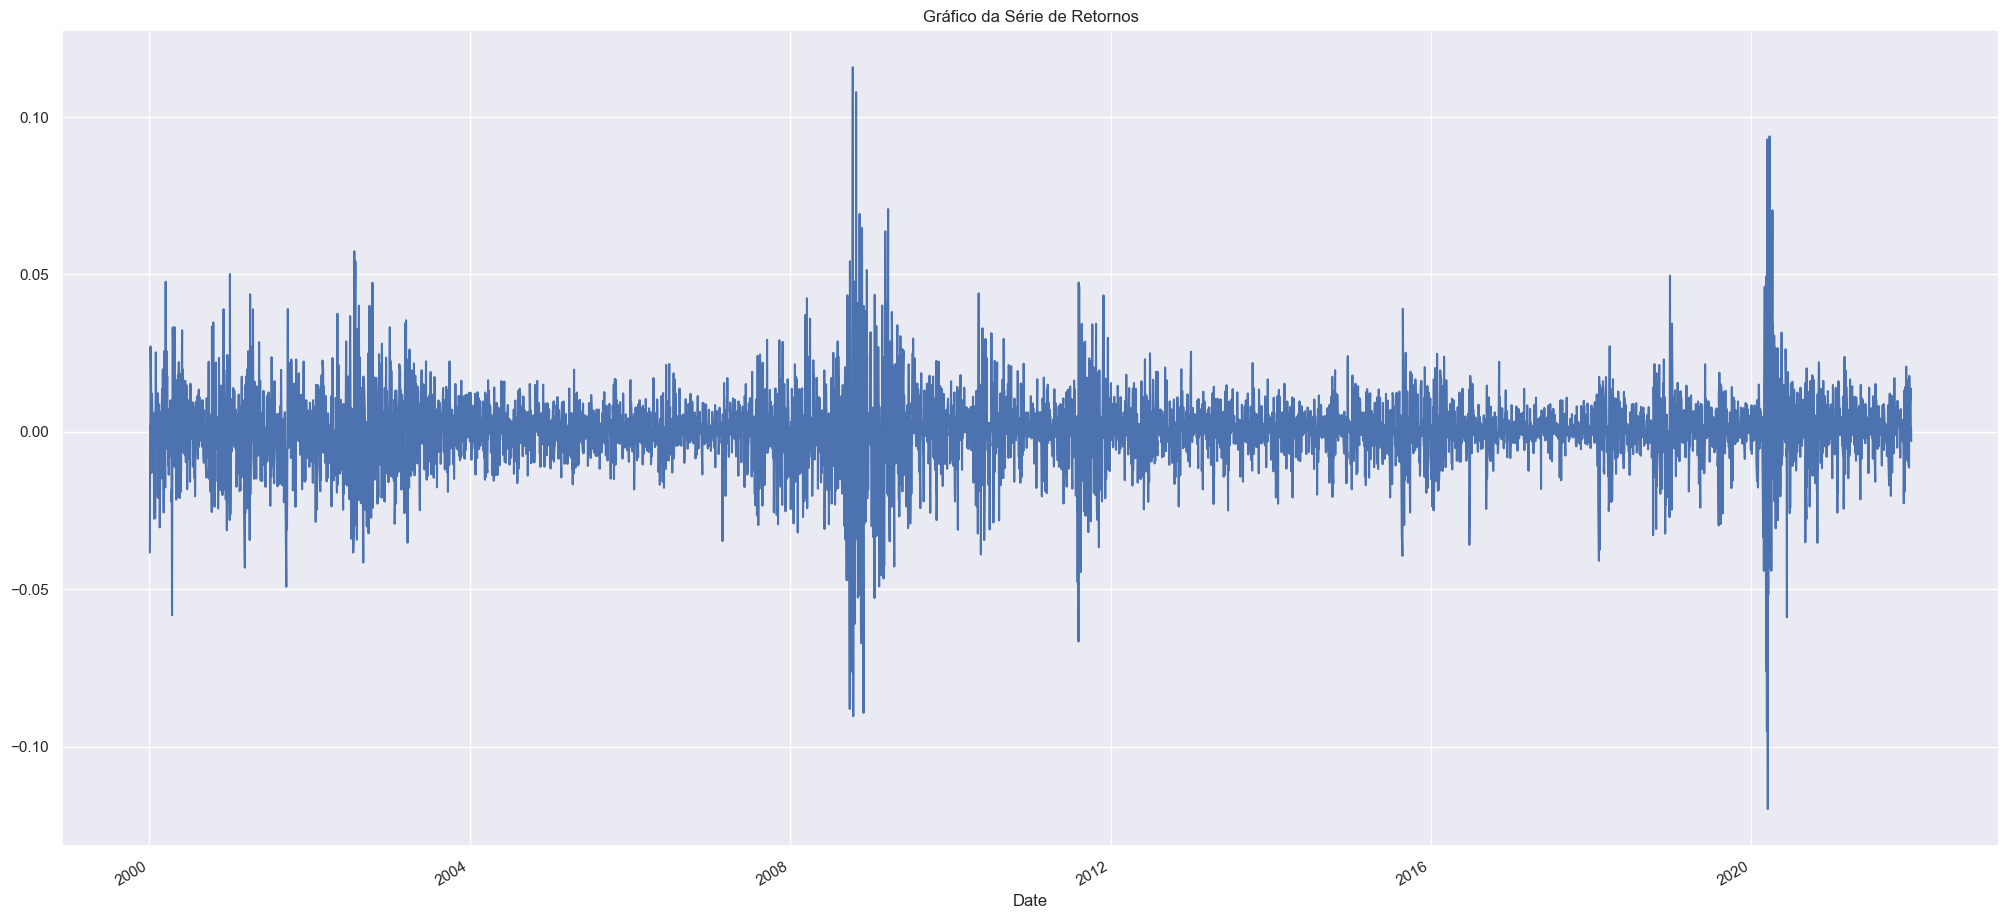

In [21]:
df4['Retorno'].plot()
plt.title( 'Gráfico da Série de Retornos' );

C:\Users\lucas\AppData\Local\Temp\ipykernel_10812\3695061061.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df4['Retorno'],


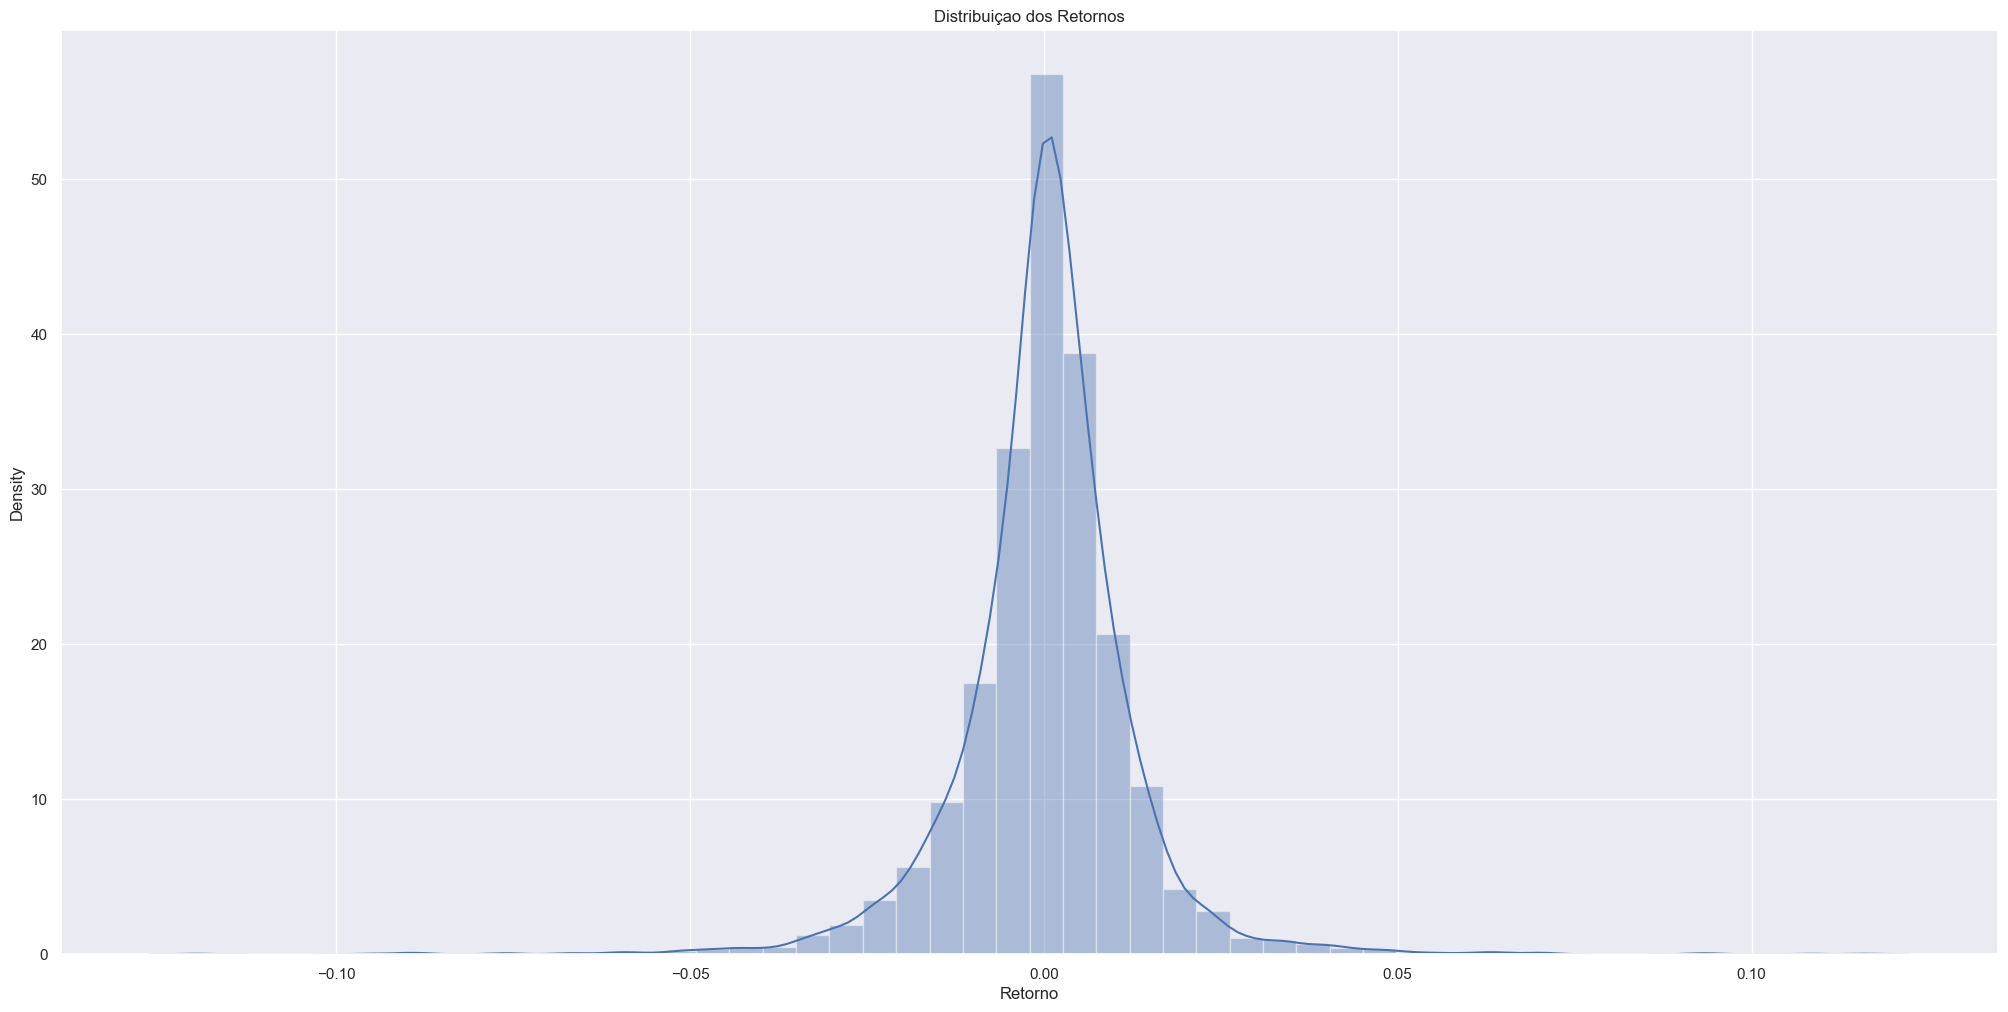

In [22]:
sns.distplot( df4['Retorno'], 
              bins = 50,
              kde=True
            )
plt.title( 'Distribuiçao dos Retornos' );

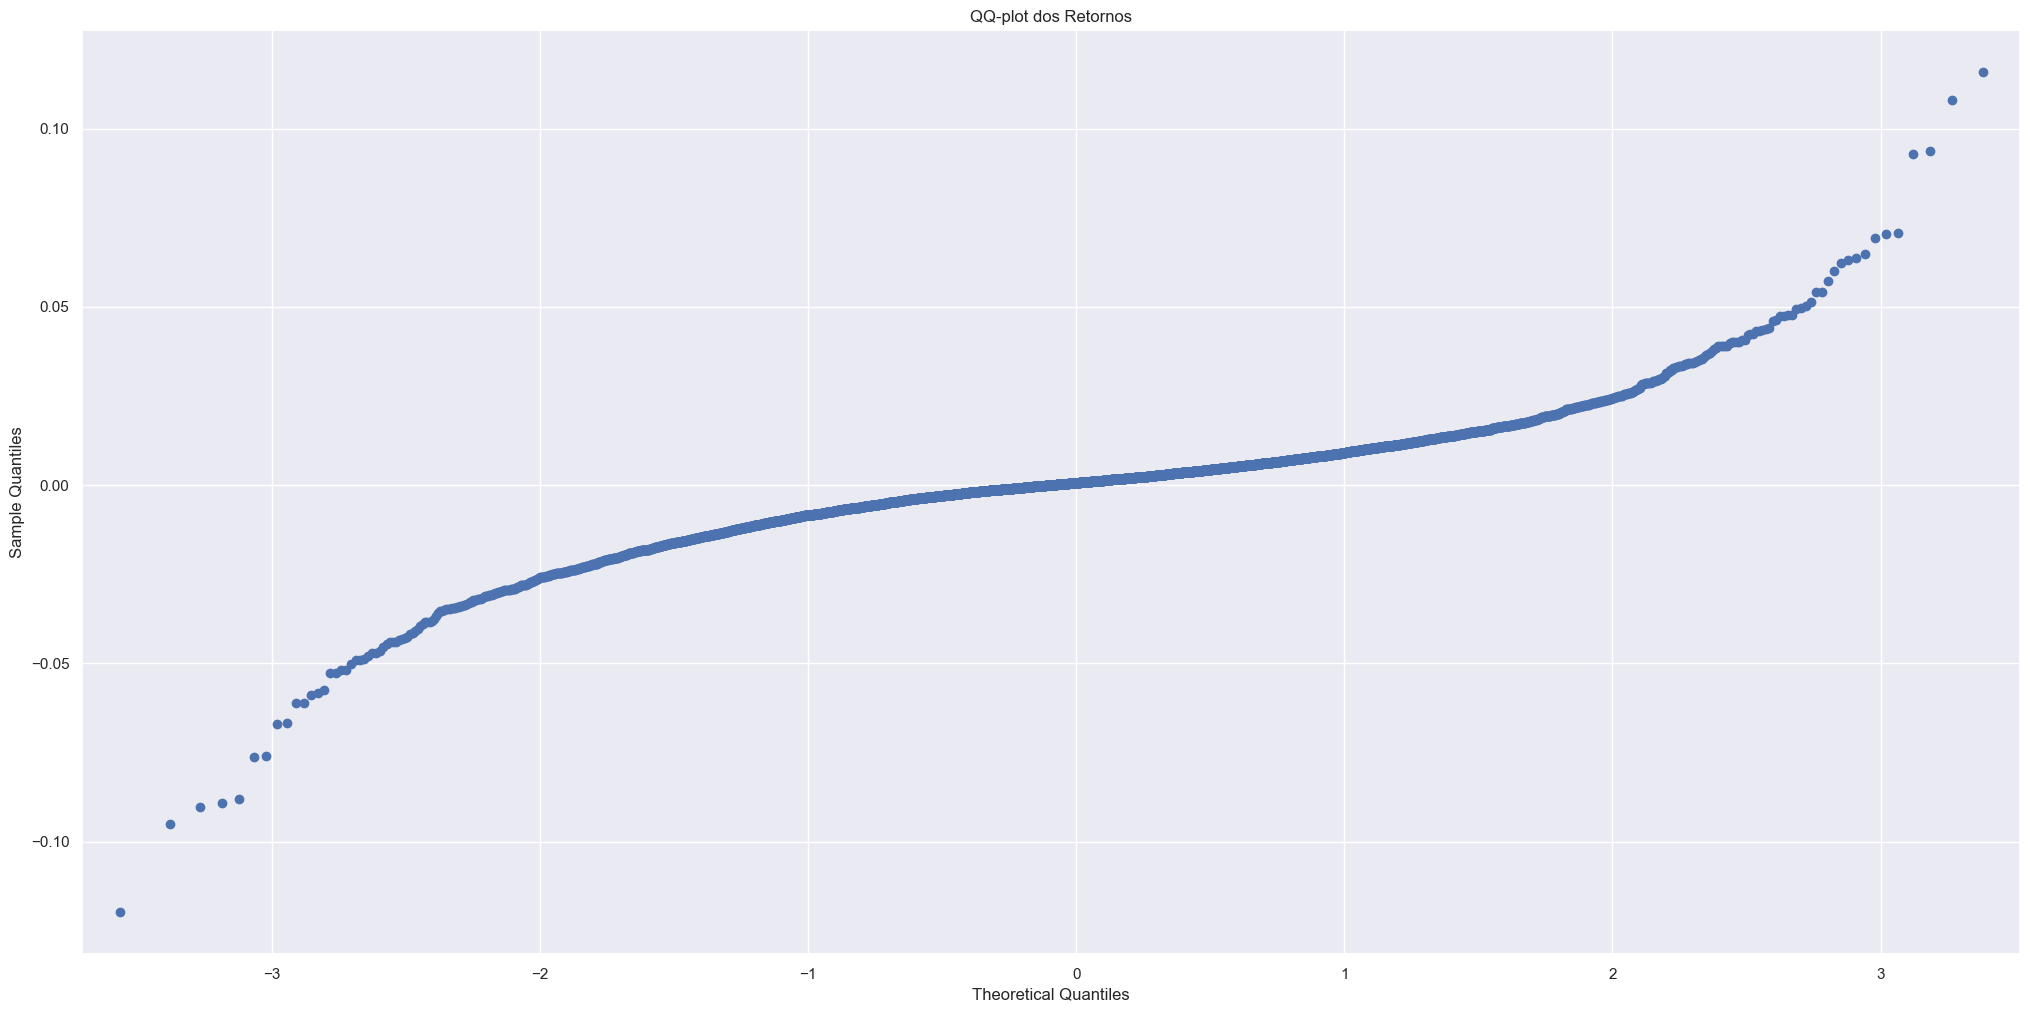

In [23]:
sm.qqplot( df4['Retorno'] )
plt.title( 'QQ-plot dos Retornos' );

Consolidando os gráficos da série histórica, série de retornos, distribuição dos retornos e qq-plot em uma mesma imagem.

C:\Users\lucas\AppData\Local\Temp\ipykernel_10812\3273338487.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df4['Retorno'],


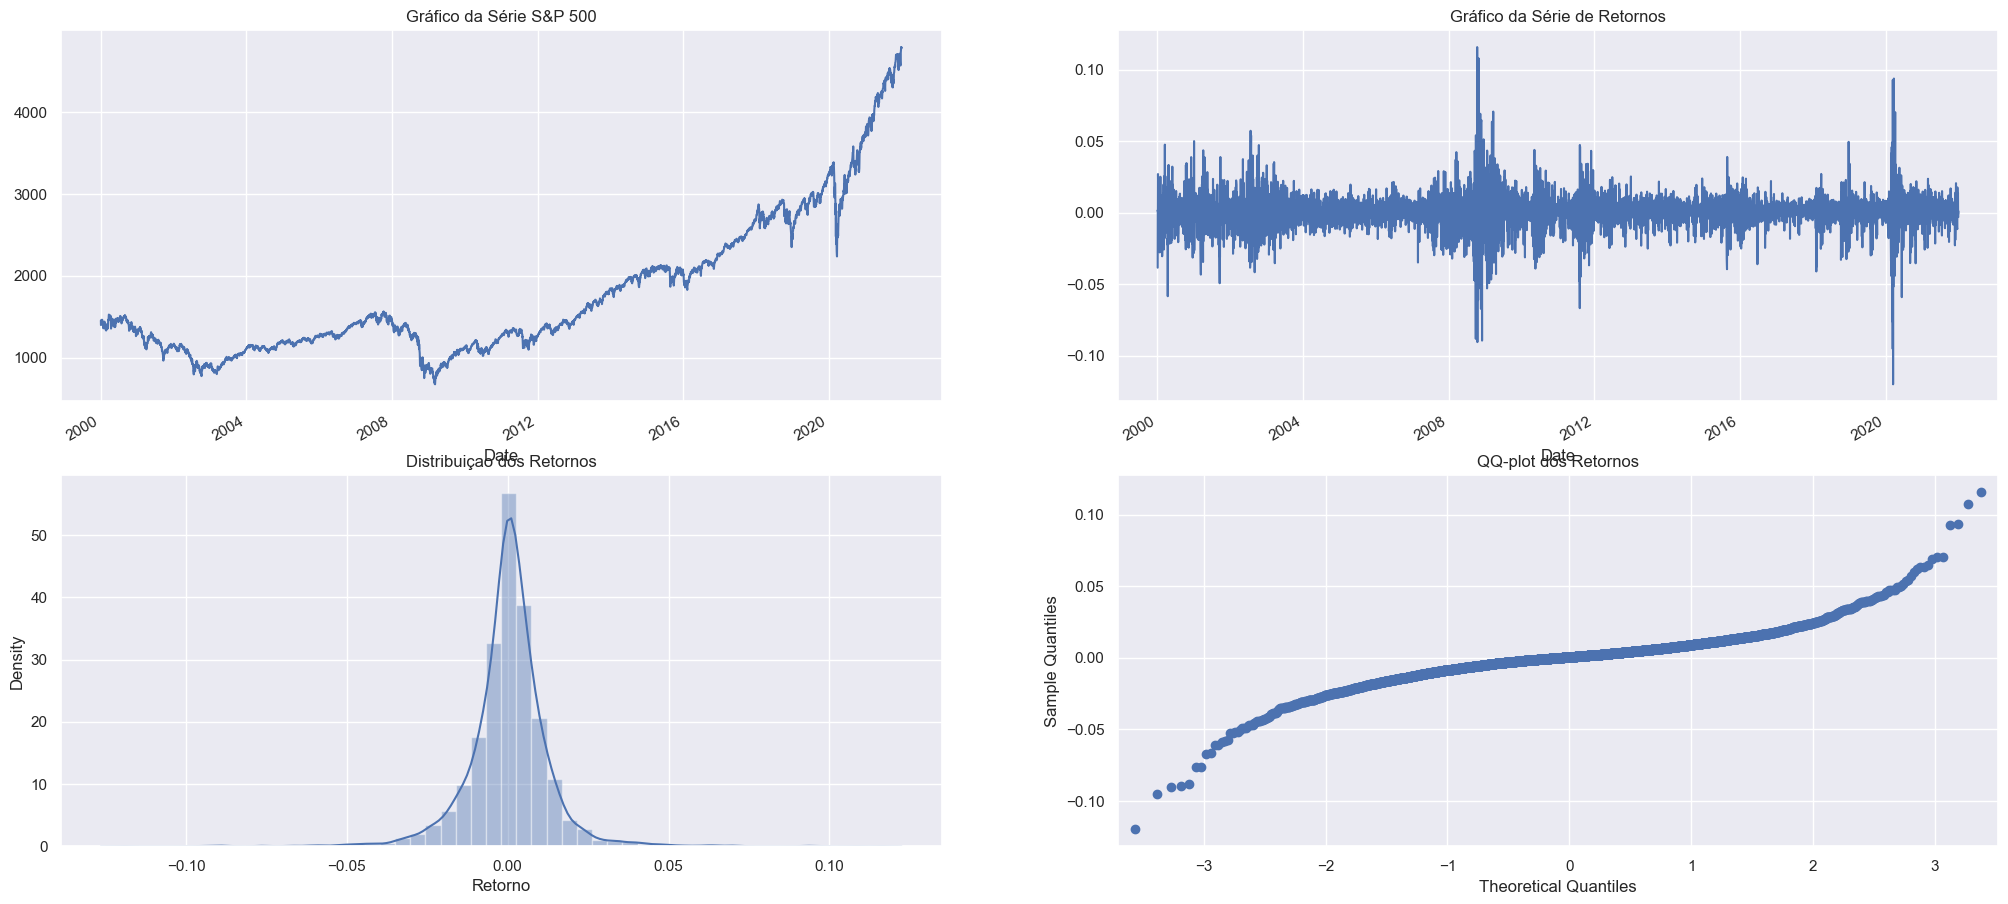

In [24]:
plt.subplot( 2, 2, 1 )
df3['Close'].plot()
plt.title( 'Gráfico da Série S&P 500' );

plt.subplot( 2, 2, 2 )
df4['Retorno'].plot()
plt.title( 'Gráfico da Série de Retornos' );

plt.subplot( 2, 2, 3 )
sns.distplot( df4['Retorno'], 
              bins = 50,
              kde=True
            )
plt.title( 'Distribuiçao dos Retornos' );

#plt.subplot( 2, 2, 4 )
sm.qqplot( df4['Retorno'], ax=plt.subplot( 2, 2, 4 ) ) 
plt.title( 'QQ-plot dos Retornos' );

In [25]:
df4['Retorno'].describe()

count    5534.000000
mean        0.000292
std         0.012370
min        -0.119841
25%        -0.004695
50%         0.000639
75%         0.005830
max         0.115800
Name: Retorno, dtype: float64

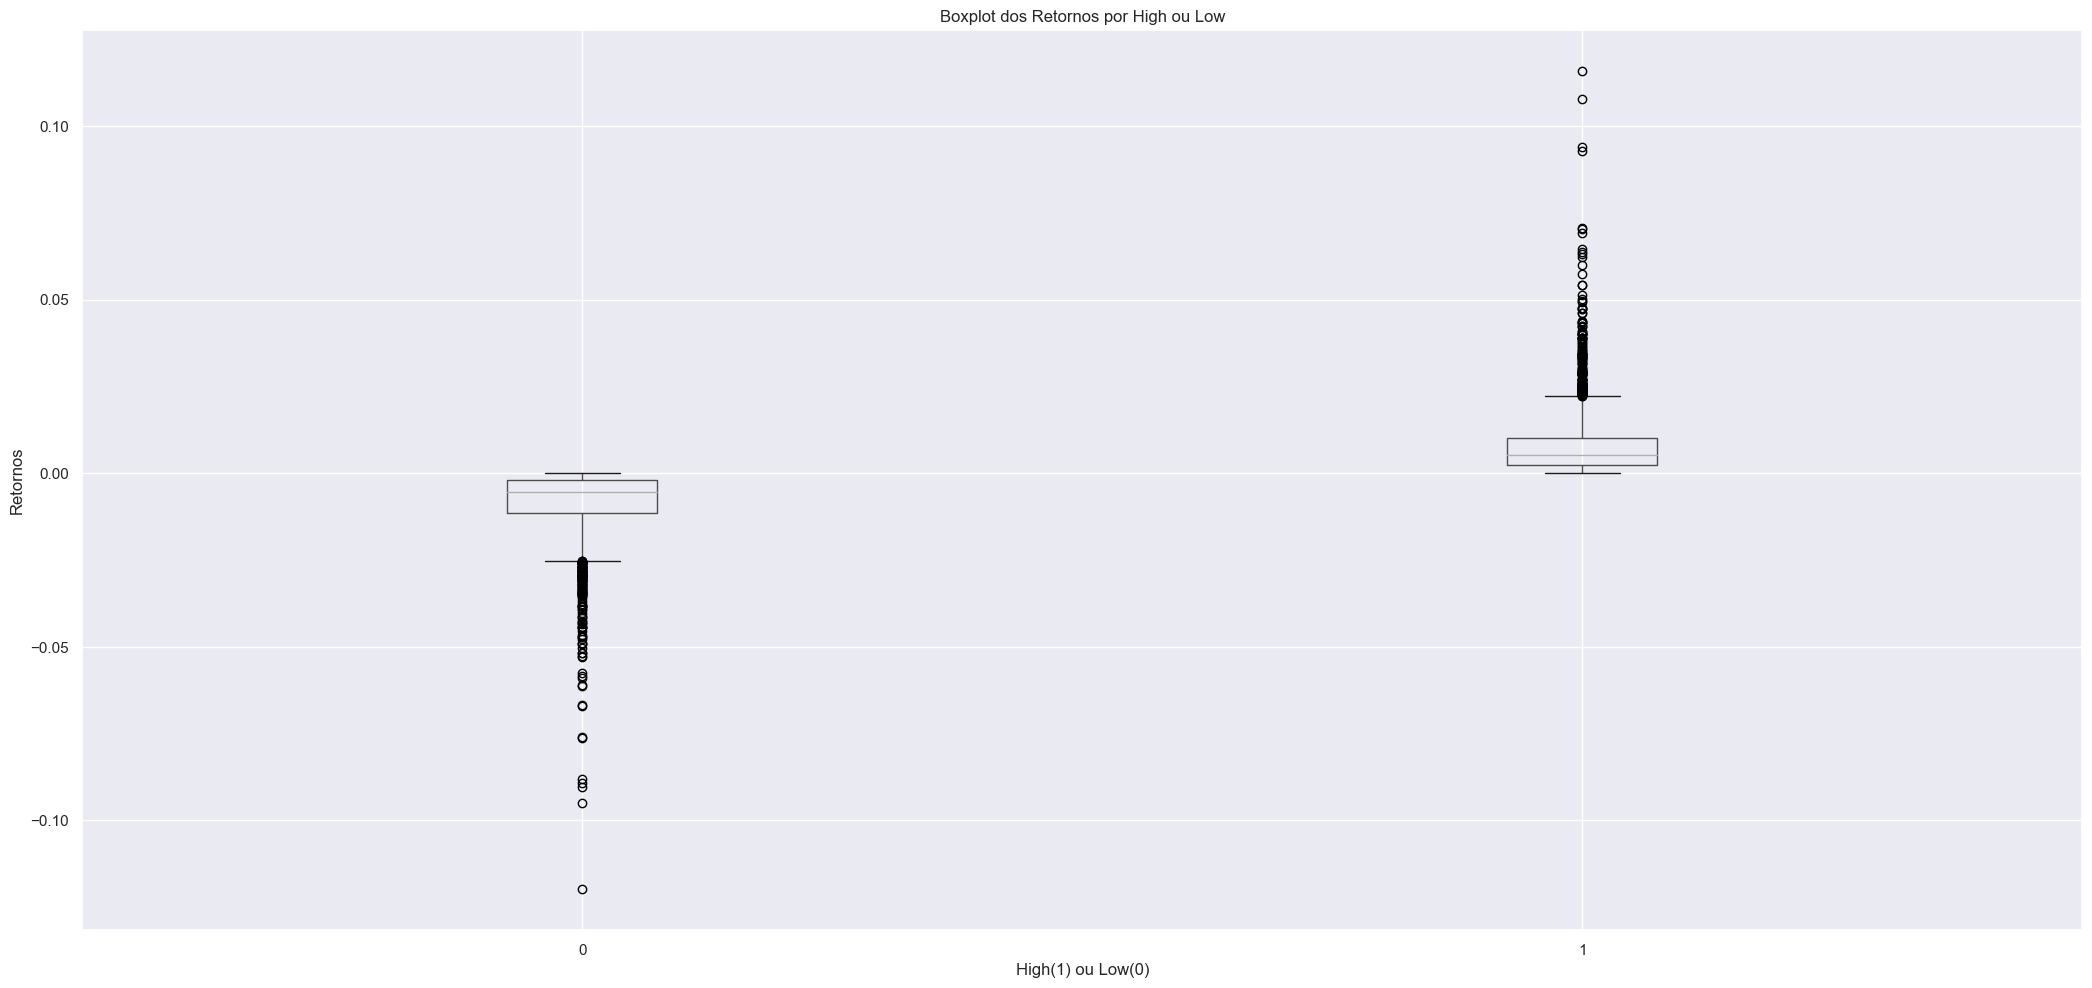

In [26]:
df4.boxplot( by='High_Low', column=['Retorno'], grid = True ) 
title = 'Boxplot dos Retornos por High ou Low'
plt.title( title )
plt.suptitle( '' ) # para eliminar o titulo padrao do boxplot do pandas
plt.ylabel( 'Retornos' )
plt.xlabel( 'High(1) ou Low(0)' )
plt.show();

# Feature Engineering

In [27]:
df5 = df4.copy()

In [28]:
df5.head()

,Open,High,Low,Close,Adj Close,Volume,Lag_P1,High_Low,Retorno
Date,,,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000,NaN,0,NaN
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,1455.219971,0,-0.038345
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,1399.420044,1,0.001922
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,1402.109985,1,0.000956
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,1403.449951,1,0.027090


## Creating targets and features

In [29]:
# Adicionando um alvo

df5["Alvo1"] = df5["Retorno"].shift( -periodos )
df5["Alvo1_Bin"] = np.where( df5["Alvo1"] > 0 , 1, 0 )

In [30]:
# Construçao das Variaveis

# Desvio Padrao de 5 dias
df5["std5"] = df5["Retorno"].rolling(5).std()

# Desvio Padrao de 10 dias
df5["std10"] = df5["Retorno"].rolling(10).std()

# Desvio Padrao de 15 dias
df5["std15"] = df5["Retorno"].rolling(15).std()

# Proporçao do corpo do candle em relacao ao range do dia
df5["prop"] = (df5["Close"]-df5["Open"])/(df5["High"]-df5["Low"])

# Direçao do dia atual
df5["dir_D"] = np.where(df5['Close'] > df5['Open'] , '1', '0')

# Direçao D-1
df5["dir_D-1"] = df5["dir_D"].shift(1)

# Direçao D-2
df5["dir_D-2"] = df5["dir_D"].shift(2)

# Direçao D-3
df5["dir_D-3"] = df5["dir_D"].shift(3)

# Media Movel de 15 dias std5
df5["mm_std5"] = df5["std5"].rolling(15).mean()

# Media Movel de 15 dias std5
df5["mm_std10"] = df5["std10"].rolling(15).mean()

# Media Movel de 15 dias std5
df5["mm_std15"] = df5["std15"].rolling(15).mean()

# RSL std5
df5["RSL_std5"] = (df5["std5"]/df5["std5"].rolling(15).mean())

# RSL std10
df5["RSL_std10"] = (df5["std10"]/df5["std10"].rolling(15).mean())

# RSL std15
df5["RSL_std15"] = (df5["std15"]/df5["std15"].rolling(15).mean())

In [31]:
# Filtrando os valores missing

df5_filtrado = df5.dropna( axis = 0 ) 

df5_filtrado= df5_filtrado.drop( ["std5","std10","std15","mm_std5","mm_std10","mm_std15"], axis = 1 )

In [32]:
#df5_filtrado["RSL_std5"] = pd.qcut(df5_filtrado["RSL_std5"], 10, labels = False)
#df5_filtrado["RSL_std10"] = pd.qcut(df5_filtrado["RSL_std10"], 10, labels = False)
#df5_filtrado["RSL_std15"] = pd.qcut(df5_filtrado["RSL_std15"], 10, labels = False)

In [33]:
df5_filtrado.head()

,Open,High,Low,Close,Adj Close,Volume,Lag_P1,High_Low,Retorno,Alvo1,Alvo1_Bin,prop,dir_D,dir_D-1,dir_D-2,dir_D-3,RSL_std5,RSL_std10,RSL_std15
Date,,,,,,,,,,,,,,,,,,,
2000-02-14,1387.119995,1394.930054,1380.530029,1389.939941,1389.939941,927300000,1387.119995,1,0.002033,0.008713,1,0.195829,1,0,1,0,1.087800,0.841834,0.986538
2000-02-15,1389.939941,1407.719971,1376.250000,1402.050049,1402.050049,1092100000,1389.939941,1,0.008713,-0.010256,0,0.384815,1,1,0,1,1.013838,0.829309,1.003464
2000-02-16,1402.050049,1404.550049,1385.579956,1387.670044,1387.670044,1018800000,1402.050049,0,-0.010256,0.000425,1,-0.758036,0,1,1,0,0.857386,0.854073,1.010178
2000-02-17,1387.670044,1399.880005,1380.069946,1388.260010,1388.260010,1034800000,1387.670044,1,0.000425,-0.030376,0,0.029781,1,0,1,1,0.833398,0.797395,1.000828
2000-02-18,1388.260010,1388.589966,1345.319946,1346.089966,1346.089966,1042300000,1388.260010,0,-0.030376,0.004517,1,-0.974579,0,1,0,1,1.091592,0.996497,1.028733


In [34]:
df5_filtrado.tail()

,Open,High,Low,Close,Adj Close,Volume,Lag_P1,High_Low,Retorno,Alvo1,Alvo1_Bin,prop,dir_D,dir_D-1,dir_D-2,dir_D-3,RSL_std5,RSL_std10,RSL_std15
Date,,,,,,,,,,,,,,,,,,,
2021-12-22,4650.359863,4697.669922,4645.529785,4696.560059,4696.560059,3319610000,4649.229980,1,0.010180,0.006224,1,0.886077,1,1,0,0,1.056588,0.931805,0.982180
2021-12-23,4703.959961,4740.740234,4703.959961,4725.790039,4725.790039,2913040000,4696.560059,1,0.006224,0.013839,1,0.593527,1,1,1,0,1.032426,0.923477,0.944751
2021-12-27,4733.990234,4791.490234,4733.990234,4791.189941,4791.189941,2770290000,4725.790039,1,0.013839,-0.001010,0,0.994778,1,1,1,1,0.925864,0.955615,0.936258
2021-12-28,4795.490234,4807.020020,4780.040039,4786.350098,4786.350098,2707920000,4791.189941,0,-0.001010,0.001402,1,-0.338775,0,1,1,1,0.617399,0.920295,0.919662
2021-12-29,4788.640137,4804.060059,4778.080078,4793.060059,4793.060059,2963310000,4786.350098,1,0.001402,-0.002990,0,0.170128,1,0,1,1,0.547805,0.897602,0.837688


In [35]:
df_dollar_euro = pdr.get_data_yahoo( 'EURUSD=X', start=start, end=end )
df_dollar_euro.rename(columns={'Close': 'USDEUR'}, inplace=True)

df_dollar_real = pdr.get_data_yahoo( 'BRL=X', start=start, end=end )['Close'].reset_index()
df_dollar_real.rename(columns={'Close': 'USDBRL'}, inplace=True)

df_oil = pdr.get_data_yahoo( 'CL=F', start=start, end=end )['Close'].reset_index()
df_oil.rename(columns={'Close': 'Oil'}, inplace=True)

df_gold = pdr.get_data_yahoo( 'GC=F', start=start, end=end )['Close'].reset_index()
df_gold.rename(columns={'Close': 'Gold'}, inplace=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [36]:
df_aux1 = df5_filtrado.merge(df_dollar_euro, on='Date').merge(df_dollar_real, on='Date').merge(df_oil, on='Date').merge(df_gold, on='Date')

In [37]:
df_aux1['USDEUR_Retorno'] = df_aux1['USDEUR'].pct_change( periodos )
df_aux1["USDEUR_Alvo1"] = df_aux1["USDEUR_Retorno"].shift( -periodos )
df_aux1["USDEUR_Bin"] = np.where( df_aux1["USDEUR_Alvo1"] > 0 , 1, 0 )

df_aux1['USDBRL_Retorno'] = df_aux1['USDBRL'].pct_change( periodos )
df_aux1["USDBRL_Alvo1"] = df_aux1["USDBRL_Retorno"].shift( -periodos )
df_aux1["USDBRL_Bin"] = np.where( df_aux1["USDBRL_Alvo1"] > 0 , 1, 0 )

df_aux1['Oil_Retorno'] = df_aux1['Oil'].pct_change( periodos )
df_aux1["Oil_Alvo1"] = df_aux1["Oil_Retorno"].shift( -periodos )
df_aux1["Oil_Bin"] = np.where( df_aux1["Oil_Alvo1"] > 0 , 1, 0 )

df_aux1['Gold_Retorno'] = df_aux1['Gold'].pct_change( periodos )
df_aux1["Gold_Alvo1"] = df_aux1["Gold_Retorno"].shift( -periodos )
df_aux1["Gold_Bin"] = np.where( df_aux1["Gold_Alvo1"] > 0 , 1, 0 )

# Machine Learning Modelling

In [38]:
df6 = df_aux1.copy()

## Split into training and test dataset

In [39]:
# Separando os dados entre treinamento e teste

# Vamos treinar o modelo de 2000 à 2017
#start_train = "2000-01-01" #"2000-02-14"
#end_train = "2017-12-31"
start_train = "2010-01-01" #"2000-02-14"
end_train = "2017-12-31"


# Vamos testar o modelo de 2018 à 2019
#start_test = "2018-01-01"
#end_test = "2019-12-31"
start_test = "2018-01-01"
end_test = "2019-12-31"

df6_train1 = df6[(df6['Date'] >= start_train) & (df6['Date'] <= end_train)]

df6_test1 = df6[(df6['Date'] >= start_test) & (df6['Date'] <= end_test)]

In [40]:
df6.columns

Index(['Date', 'Open_x', 'High_x', 'Low_x', 'Close', 'Adj Close_x', 'Volume_x',
       'Lag_P1', 'High_Low', 'Retorno', 'Alvo1', 'Alvo1_Bin', 'prop', 'dir_D',
       'dir_D-1', 'dir_D-2', 'dir_D-3', 'RSL_std5', 'RSL_std10', 'RSL_std15',
       'Open_y', 'High_y', 'Low_y', 'USDEUR', 'Adj Close_y', 'Volume_y',
       'USDBRL', 'Oil', 'Gold', 'USDEUR_Retorno', 'USDEUR_Alvo1', 'USDEUR_Bin',
       'USDBRL_Retorno', 'USDBRL_Alvo1', 'USDBRL_Bin', 'Oil_Retorno',
       'Oil_Alvo1', 'Oil_Bin', 'Gold_Retorno', 'Gold_Alvo1', 'Gold_Bin'],
      dtype='object')

In [41]:
# Separando os dados com as variaveis em x e o alvo em y
 
x_train1 = df6_train1[['prop', 'dir_D', 'dir_D-1','dir_D-2', 'dir_D-3', 'RSL_std5', 'RSL_std10', 'RSL_std15']]
y_train1 = df6_train1['Alvo1_Bin']
#y_train1 = df6_train1['Alvo1']


x_test1 = df6_test1[['prop', 'dir_D', 'dir_D-1','dir_D-2', 'dir_D-3', 'RSL_std5', 'RSL_std10', 'RSL_std15']]
y_test1 = df6_test1['Alvo1_Bin']
#y_test1 = df6_test1['Alvo1']

# Logistic Regression

In [42]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression( random_state=42 ).fit( x_train1, y_train1)
lr_pred = lr_model.predict( x_test1 )

In [43]:
# Teste

print(confusion_matrix( y_test1, lr_pred ) )
print()
print("--------------------------------------------------------------------------------")
print()
print(classification_report( y_test1, lr_pred ) )

[[ 20 199]
 [ 36 246]]

--------------------------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.36      0.09      0.15       219
           1       0.55      0.87      0.68       282

    accuracy                           0.53       501
   macro avg       0.45      0.48      0.41       501
weighted avg       0.47      0.53      0.44       501



In [44]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve( y_test1, lr_pred )
auc( fpr, tpr )

0.48183231322257847

C:\Users\lucas\anaconda3\envs\py_env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


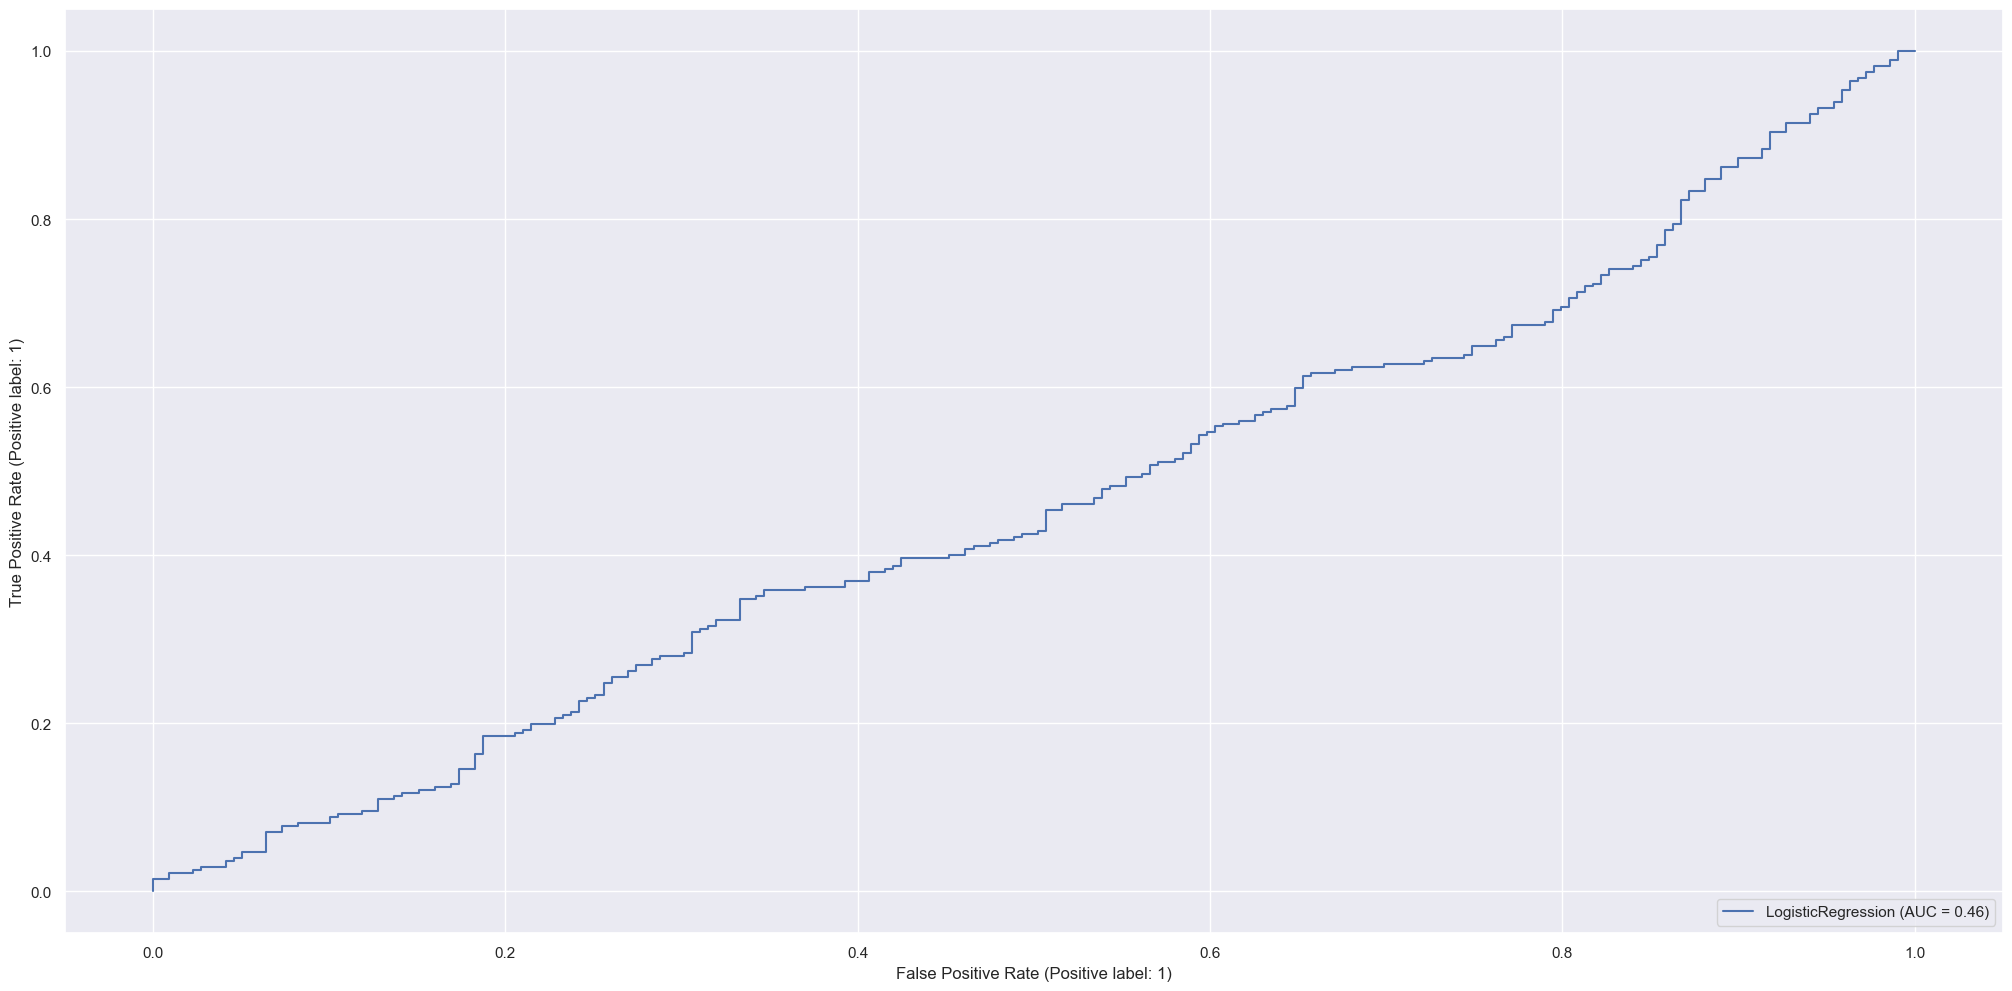

In [45]:
plot_roc_curve(lr_model, x_test1, y_test1)

# Neural Networks

## Feature Scaling

In [46]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

sc = MinMaxScaler( feature_range = (0, 1) )
#sc = StandardScaler()
x_train1 = sc.fit_transform( x_train1 )

## Reshaping

In [47]:
#x_train1.head()

In [48]:
x_train1 = np.asarray( x_train1 ).astype( np.float32 )
x_train1 = np.reshape( x_train1, ( x_train1.shape[0], x_train1.shape[1], 1 ) )

## Initialising the RNN

In [49]:
clf = Sequential()

## Adding the first layer and dropout regularisation

In [50]:
clf.add( LSTM( units = 100, return_sequences = True, input_shape = ( x_train1.shape[1], 1 ), dropout=0.2, recurrent_dropout=0.2 ) )
#clf.add( Dropout( 0.2 ) )

## Adding a second layer and dropout regularisation

In [51]:
clf.add( LSTM( units = 100, return_sequences = True, activation='relu', dropout=0.2, recurrent_dropout=0.2 ) )
#clf.add( Dropout( 0.2 ) )

## Adding a third layer and dropout regularisation

In [52]:
clf.add( LSTM( units = 100, return_sequences = True, activation='relu', dropout=0.2, recurrent_dropout=0.2 ) )
#clf.add( Dropout( 0.2 ) )

## Adding a fourth layer and dropout regularisation

In [53]:
clf.add( LSTM( units = 100, activation='relu', dropout=0.2, recurrent_dropout=0.2) )
#clf.add( Dropout( 0.2 ) )

## Adding the output layer and dropout regularisation

In [54]:
clf.add( Dense( units = 1, activation='sigmoid' ) )

## Compiling the RNN

In [55]:
clf.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'] )
#clf.compile( optimizer = 'adam', loss = 'mean_squared_error', metrics=[mean_squared_error] )

## Fitting the RNN

In [56]:
clf.fit( x_train1, y_train1, epochs = 5000, batch_size = 50, shuffle=False )

Epoch 1/5000
41/41 [==============================] - 10s 37ms/step - loss: 0.6915 - accuracy: 0.5456
Epoch 2/5000
41/41 [==============================] - 1s 36ms/step - loss: 0.6900 - accuracy: 0.5456
Epoch 3/5000
41/41 [==============================] - 2s 37ms/step - loss: 0.6896 - accuracy: 0.5456
Epoch 4/5000
41/41 [==============================] - 2s 43ms/step - loss: 0.6896 - accuracy: 0.5456
Epoch 5/5000
41/41 [==============================] - 2s 44ms/step - loss: 0.6894 - accuracy: 0.5456
Epoch 6/5000
41/41 [==============================] - 2s 42ms/step - loss: 0.6894 - accuracy: 0.5456
Epoch 7/5000
41/41 [==============================] - 2s 38ms/step - loss: 0.6893 - accuracy: 0.5456
Epoch 8/5000
41/41 [==============================] - 2s 37ms/step - loss: 0.6893 - accuracy: 0.5456
Epoch 9/5000
41/41 [==============================] - 2s 39ms/step - loss: 0.6892 - accuracy: 0.5421
Epoch 10/5000
41/41 [==============================] - 2s 53ms/step - loss: 0.6897 - accur

41/41 [==============================] - 2s 52ms/step - loss: 0.6888 - accuracy: 0.5456
Epoch 82/5000
41/41 [==============================] - 2s 52ms/step - loss: 0.6882 - accuracy: 0.5456
Epoch 83/5000
41/41 [==============================] - 2s 56ms/step - loss: 0.6893 - accuracy: 0.5456
Epoch 84/5000
41/41 [==============================] - 2s 50ms/step - loss: 0.6880 - accuracy: 0.5456
Epoch 85/5000
41/41 [==============================] - 2s 48ms/step - loss: 0.6879 - accuracy: 0.5456
Epoch 86/5000
41/41 [==============================] - 2s 48ms/step - loss: 0.6873 - accuracy: 0.5426
Epoch 87/5000
41/41 [==============================] - 2s 53ms/step - loss: 0.6875 - accuracy: 0.5586
Epoch 88/5000
41/41 [==============================] - 2s 52ms/step - loss: 0.6889 - accuracy: 0.5436
Epoch 89/5000
41/41 [==============================] - 2s 53ms/step - loss: 0.6883 - accuracy: 0.5466
Epoch 90/5000
41/41 [==============================] - 2s 52ms/step - loss: 0.6890 - accuracy: 0

41/41 [==============================] - 3s 75ms/step - loss: 0.6876 - accuracy: 0.5541
Epoch 161/5000
41/41 [==============================] - 3s 72ms/step - loss: 0.6885 - accuracy: 0.5401
Epoch 162/5000
41/41 [==============================] - 3s 72ms/step - loss: 0.6882 - accuracy: 0.5441
Epoch 163/5000
41/41 [==============================] - 3s 77ms/step - loss: 0.6887 - accuracy: 0.5456
Epoch 164/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.6881 - accuracy: 0.5456
Epoch 165/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.6882 - accuracy: 0.5451
Epoch 166/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.6873 - accuracy: 0.5466
Epoch 167/5000
41/41 [==============================] - 3s 78ms/step - loss: 0.6891 - accuracy: 0.5387
Epoch 168/5000
41/41 [==============================] - 3s 77ms/step - loss: 0.6868 - accuracy: 0.5516
Epoch 169/5000
41/41 [==============================] - 3s 85ms/step - loss: 0.6880 - ac

41/41 [==============================] - 3s 69ms/step - loss: 0.6867 - accuracy: 0.5461
Epoch 240/5000
41/41 [==============================] - 3s 71ms/step - loss: 0.6854 - accuracy: 0.5491
Epoch 241/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.6884 - accuracy: 0.5521
Epoch 242/5000
41/41 [==============================] - 3s 71ms/step - loss: 0.6867 - accuracy: 0.5511
Epoch 243/5000
41/41 [==============================] - 3s 70ms/step - loss: 0.6882 - accuracy: 0.5491
Epoch 244/5000
41/41 [==============================] - 3s 70ms/step - loss: 0.6878 - accuracy: 0.5387
Epoch 245/5000
41/41 [==============================] - 3s 69ms/step - loss: 0.6862 - accuracy: 0.5496
Epoch 246/5000
41/41 [==============================] - 3s 70ms/step - loss: 0.6880 - accuracy: 0.5476
Epoch 247/5000
41/41 [==============================] - 3s 70ms/step - loss: 0.6863 - accuracy: 0.5491
Epoch 248/5000
41/41 [==============================] - 3s 69ms/step - loss: 0.6867 - ac

41/41 [==============================] - 3s 70ms/step - loss: 0.6894 - accuracy: 0.5436
Epoch 319/5000
41/41 [==============================] - 3s 70ms/step - loss: 0.6861 - accuracy: 0.5476
Epoch 320/5000
41/41 [==============================] - 3s 69ms/step - loss: 0.6856 - accuracy: 0.5476
Epoch 321/5000
41/41 [==============================] - 3s 70ms/step - loss: 0.6865 - accuracy: 0.5431
Epoch 322/5000
41/41 [==============================] - 3s 70ms/step - loss: 0.6874 - accuracy: 0.5511
Epoch 323/5000
41/41 [==============================] - 3s 70ms/step - loss: 0.6852 - accuracy: 0.5451
Epoch 324/5000
41/41 [==============================] - 3s 71ms/step - loss: 0.6880 - accuracy: 0.5372
Epoch 325/5000
41/41 [==============================] - 3s 70ms/step - loss: 0.6866 - accuracy: 0.5496
Epoch 326/5000
41/41 [==============================] - 3s 71ms/step - loss: 0.6866 - accuracy: 0.5436
Epoch 327/5000
41/41 [==============================] - 3s 70ms/step - loss: 0.6871 - ac

41/41 [==============================] - 3s 70ms/step - loss: 0.6874 - accuracy: 0.5382
Epoch 398/5000
41/41 [==============================] - 3s 71ms/step - loss: 0.6861 - accuracy: 0.5421
Epoch 399/5000
41/41 [==============================] - 3s 71ms/step - loss: 0.6853 - accuracy: 0.5411
Epoch 400/5000
41/41 [==============================] - 3s 71ms/step - loss: 0.6862 - accuracy: 0.5601
Epoch 401/5000
41/41 [==============================] - 3s 70ms/step - loss: 0.6875 - accuracy: 0.5581
Epoch 402/5000
41/41 [==============================] - 3s 71ms/step - loss: 0.6876 - accuracy: 0.5397
Epoch 403/5000
41/41 [==============================] - 3s 71ms/step - loss: 0.6859 - accuracy: 0.5511
Epoch 404/5000
41/41 [==============================] - 3s 71ms/step - loss: 0.6871 - accuracy: 0.5426
Epoch 405/5000
41/41 [==============================] - 3s 70ms/step - loss: 0.6847 - accuracy: 0.5536
Epoch 406/5000
41/41 [==============================] - 3s 71ms/step - loss: 0.6865 - ac

41/41 [==============================] - 3s 72ms/step - loss: 0.6848 - accuracy: 0.5501
Epoch 477/5000
41/41 [==============================] - 3s 71ms/step - loss: 0.6867 - accuracy: 0.5436
Epoch 478/5000
41/41 [==============================] - 3s 71ms/step - loss: 0.6851 - accuracy: 0.5486
Epoch 479/5000
41/41 [==============================] - 3s 71ms/step - loss: 0.6864 - accuracy: 0.5496
Epoch 480/5000
41/41 [==============================] - 3s 72ms/step - loss: 0.6857 - accuracy: 0.5536
Epoch 481/5000
41/41 [==============================] - 3s 72ms/step - loss: 0.6845 - accuracy: 0.5551
Epoch 482/5000
41/41 [==============================] - 3s 72ms/step - loss: 0.6849 - accuracy: 0.5506
Epoch 483/5000
41/41 [==============================] - 3s 71ms/step - loss: 0.6863 - accuracy: 0.5586
Epoch 484/5000
41/41 [==============================] - 3s 71ms/step - loss: 0.6835 - accuracy: 0.5506
Epoch 485/5000
41/41 [==============================] - 3s 72ms/step - loss: 0.6848 - ac

41/41 [==============================] - 3s 72ms/step - loss: 0.6821 - accuracy: 0.5626
Epoch 556/5000
41/41 [==============================] - 3s 72ms/step - loss: 0.6864 - accuracy: 0.5471
Epoch 557/5000
41/41 [==============================] - 3s 71ms/step - loss: 0.6814 - accuracy: 0.5531
Epoch 558/5000
41/41 [==============================] - 3s 71ms/step - loss: 0.6847 - accuracy: 0.5481
Epoch 559/5000
41/41 [==============================] - 3s 71ms/step - loss: 0.6848 - accuracy: 0.5446
Epoch 560/5000
41/41 [==============================] - 3s 72ms/step - loss: 0.6847 - accuracy: 0.5536
Epoch 561/5000
41/41 [==============================] - 3s 72ms/step - loss: 0.6826 - accuracy: 0.5601
Epoch 562/5000
41/41 [==============================] - 3s 72ms/step - loss: 0.6843 - accuracy: 0.5481
Epoch 563/5000
41/41 [==============================] - 3s 71ms/step - loss: 0.6843 - accuracy: 0.5501
Epoch 564/5000
41/41 [==============================] - 3s 72ms/step - loss: 0.6846 - ac

41/41 [==============================] - 3s 73ms/step - loss: 0.6829 - accuracy: 0.5576
Epoch 635/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.6845 - accuracy: 0.5516
Epoch 636/5000
41/41 [==============================] - 3s 72ms/step - loss: 0.6796 - accuracy: 0.5526
Epoch 637/5000
41/41 [==============================] - 3s 72ms/step - loss: 0.6826 - accuracy: 0.5591
Epoch 638/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.6786 - accuracy: 0.5551
Epoch 639/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.6849 - accuracy: 0.5566
Epoch 640/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.6794 - accuracy: 0.5531
Epoch 641/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.6834 - accuracy: 0.5496
Epoch 642/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.6793 - accuracy: 0.5576
Epoch 643/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.6821 - ac

41/41 [==============================] - 3s 72ms/step - loss: 0.6804 - accuracy: 0.5616
Epoch 714/5000
41/41 [==============================] - 3s 72ms/step - loss: 0.6800 - accuracy: 0.5566
Epoch 715/5000
41/41 [==============================] - 3s 71ms/step - loss: 0.6785 - accuracy: 0.5746
Epoch 716/5000
41/41 [==============================] - 3s 72ms/step - loss: 0.6787 - accuracy: 0.5661
Epoch 717/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.6815 - accuracy: 0.5581
Epoch 718/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.6812 - accuracy: 0.5456
Epoch 719/5000
41/41 [==============================] - 3s 72ms/step - loss: 0.6819 - accuracy: 0.5571
Epoch 720/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.6804 - accuracy: 0.5631
Epoch 721/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.6826 - accuracy: 0.5496
Epoch 722/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.6835 - ac

41/41 [==============================] - 3s 73ms/step - loss: 0.6770 - accuracy: 0.5716
Epoch 793/5000
41/41 [==============================] - 3s 72ms/step - loss: 0.6747 - accuracy: 0.5611
Epoch 794/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.6772 - accuracy: 0.5666
Epoch 795/5000
41/41 [==============================] - 3s 72ms/step - loss: 0.6779 - accuracy: 0.5716
Epoch 796/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.6738 - accuracy: 0.5716
Epoch 797/5000
41/41 [==============================] - 3s 72ms/step - loss: 0.6759 - accuracy: 0.5616
Epoch 798/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.6759 - accuracy: 0.5746
Epoch 799/5000
41/41 [==============================] - 3s 72ms/step - loss: 0.6753 - accuracy: 0.5706
Epoch 800/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.6732 - accuracy: 0.5681
Epoch 801/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.6801 - ac

41/41 [==============================] - 3s 72ms/step - loss: 0.6773 - accuracy: 0.5551
Epoch 872/5000
41/41 [==============================] - 3s 72ms/step - loss: 0.6725 - accuracy: 0.5661
Epoch 873/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.6724 - accuracy: 0.5711
Epoch 874/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.6760 - accuracy: 0.5805
Epoch 875/5000
41/41 [==============================] - 3s 71ms/step - loss: 0.6687 - accuracy: 0.5771
Epoch 876/5000
41/41 [==============================] - 3s 72ms/step - loss: 0.6762 - accuracy: 0.5666
Epoch 877/5000
41/41 [==============================] - 3s 72ms/step - loss: 0.6803 - accuracy: 0.5686
Epoch 878/5000
41/41 [==============================] - 3s 72ms/step - loss: 0.6761 - accuracy: 0.5566
Epoch 879/5000
41/41 [==============================] - 3s 72ms/step - loss: 0.6767 - accuracy: 0.5611
Epoch 880/5000
41/41 [==============================] - 3s 72ms/step - loss: 0.6719 - ac

41/41 [==============================] - 3s 66ms/step - loss: 0.6695 - accuracy: 0.5706
Epoch 951/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.6761 - accuracy: 0.5701
Epoch 952/5000
41/41 [==============================] - 3s 65ms/step - loss: 0.6727 - accuracy: 0.5666
Epoch 953/5000
41/41 [==============================] - 3s 65ms/step - loss: 0.6735 - accuracy: 0.5796
Epoch 954/5000
41/41 [==============================] - 3s 65ms/step - loss: 0.6712 - accuracy: 0.5860
Epoch 955/5000
41/41 [==============================] - 3s 64ms/step - loss: 0.6641 - accuracy: 0.5890
Epoch 956/5000
41/41 [==============================] - 3s 64ms/step - loss: 0.6734 - accuracy: 0.5771
Epoch 957/5000
41/41 [==============================] - 3s 64ms/step - loss: 0.6751 - accuracy: 0.5736
Epoch 958/5000
41/41 [==============================] - 3s 64ms/step - loss: 0.6684 - accuracy: 0.5880
Epoch 959/5000
41/41 [==============================] - 3s 63ms/step - loss: 0.6725 - ac

41/41 [==============================] - 3s 64ms/step - loss: 0.6674 - accuracy: 0.5815
Epoch 1030/5000
41/41 [==============================] - 3s 64ms/step - loss: 0.6660 - accuracy: 0.5786
Epoch 1031/5000
41/41 [==============================] - 3s 64ms/step - loss: 0.6606 - accuracy: 0.5776
Epoch 1032/5000
41/41 [==============================] - 3s 64ms/step - loss: 0.6689 - accuracy: 0.5915
Epoch 1033/5000
41/41 [==============================] - 3s 64ms/step - loss: 0.6669 - accuracy: 0.5771
Epoch 1034/5000
41/41 [==============================] - 3s 65ms/step - loss: 0.6694 - accuracy: 0.5726
Epoch 1035/5000
41/41 [==============================] - 3s 64ms/step - loss: 0.6722 - accuracy: 0.5885
Epoch 1036/5000
41/41 [==============================] - 3s 64ms/step - loss: 0.6711 - accuracy: 0.5711
Epoch 1037/5000
41/41 [==============================] - 3s 65ms/step - loss: 0.6690 - accuracy: 0.5910
Epoch 1038/5000
41/41 [==============================] - 3s 65ms/step - loss: 0.

41/41 [==============================] - 3s 64ms/step - loss: 0.6559 - accuracy: 0.5950
Epoch 1108/5000
41/41 [==============================] - 3s 65ms/step - loss: 0.6686 - accuracy: 0.5776
Epoch 1109/5000
41/41 [==============================] - 3s 65ms/step - loss: 0.6620 - accuracy: 0.5960
Epoch 1110/5000
41/41 [==============================] - 3s 64ms/step - loss: 0.6664 - accuracy: 0.5940
Epoch 1111/5000
41/41 [==============================] - 3s 64ms/step - loss: 0.6606 - accuracy: 0.5910
Epoch 1112/5000
41/41 [==============================] - 3s 65ms/step - loss: 0.6580 - accuracy: 0.5930
Epoch 1113/5000
41/41 [==============================] - 3s 65ms/step - loss: 0.6646 - accuracy: 0.5925
Epoch 1114/5000
41/41 [==============================] - 3s 65ms/step - loss: 0.6716 - accuracy: 0.5800
Epoch 1115/5000
41/41 [==============================] - 3s 64ms/step - loss: 0.6698 - accuracy: 0.5810
Epoch 1116/5000
41/41 [==============================] - 3s 63ms/step - loss: 0.

41/41 [==============================] - 3s 65ms/step - loss: 0.6665 - accuracy: 0.5825
Epoch 1186/5000
41/41 [==============================] - 3s 66ms/step - loss: 0.6595 - accuracy: 0.5915
Epoch 1187/5000
41/41 [==============================] - 3s 65ms/step - loss: 0.6548 - accuracy: 0.5940
Epoch 1188/5000
41/41 [==============================] - 3s 66ms/step - loss: 0.6639 - accuracy: 0.5910
Epoch 1189/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.6544 - accuracy: 0.6110
Epoch 1190/5000
41/41 [==============================] - 3s 66ms/step - loss: 0.6690 - accuracy: 0.5761
Epoch 1191/5000
41/41 [==============================] - 3s 66ms/step - loss: 0.6546 - accuracy: 0.6110
Epoch 1192/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.6651 - accuracy: 0.5890
Epoch 1193/5000
41/41 [==============================] - 3s 66ms/step - loss: 0.6568 - accuracy: 0.5980
Epoch 1194/5000
41/41 [==============================] - 3s 65ms/step - loss: 0.

41/41 [==============================] - 3s 68ms/step - loss: 0.6607 - accuracy: 0.6070
Epoch 1264/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.6538 - accuracy: 0.5995
Epoch 1265/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.6596 - accuracy: 0.5990
Epoch 1266/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.6544 - accuracy: 0.6145
Epoch 1267/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.6460 - accuracy: 0.6195
Epoch 1268/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.6614 - accuracy: 0.5955
Epoch 1269/5000
41/41 [==============================] - 3s 66ms/step - loss: 0.6577 - accuracy: 0.5935
Epoch 1270/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.6507 - accuracy: 0.5955
Epoch 1271/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.6571 - accuracy: 0.6020
Epoch 1272/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.

41/41 [==============================] - 3s 66ms/step - loss: 0.6504 - accuracy: 0.6095
Epoch 1342/5000
41/41 [==============================] - 3s 66ms/step - loss: 0.6618 - accuracy: 0.5870
Epoch 1343/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.6535 - accuracy: 0.6030
Epoch 1344/5000
41/41 [==============================] - 3s 66ms/step - loss: 0.6409 - accuracy: 0.6160
Epoch 1345/5000
41/41 [==============================] - 3s 66ms/step - loss: 0.6457 - accuracy: 0.6030
Epoch 1346/5000
41/41 [==============================] - 3s 68ms/step - loss: 0.6441 - accuracy: 0.6140
Epoch 1347/5000
41/41 [==============================] - 3s 69ms/step - loss: 0.6557 - accuracy: 0.6045
Epoch 1348/5000
41/41 [==============================] - 3s 68ms/step - loss: 0.6463 - accuracy: 0.6185
Epoch 1349/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.6503 - accuracy: 0.5975
Epoch 1350/5000
41/41 [==============================] - 3s 69ms/step - loss: 0.

41/41 [==============================] - 3s 66ms/step - loss: 0.6468 - accuracy: 0.6070
Epoch 1420/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.6460 - accuracy: 0.6015
Epoch 1421/5000
41/41 [==============================] - 3s 68ms/step - loss: 0.6422 - accuracy: 0.6140
Epoch 1422/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.6405 - accuracy: 0.6125
Epoch 1423/5000
41/41 [==============================] - 3s 66ms/step - loss: 0.6375 - accuracy: 0.6155
Epoch 1424/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.6476 - accuracy: 0.6195
Epoch 1425/5000
41/41 [==============================] - 3s 66ms/step - loss: 0.6360 - accuracy: 0.6214
Epoch 1426/5000
41/41 [==============================] - 3s 68ms/step - loss: 0.6414 - accuracy: 0.6214
Epoch 1427/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.6413 - accuracy: 0.6140
Epoch 1428/5000
41/41 [==============================] - 3s 66ms/step - loss: 0.

41/41 [==============================] - 3s 66ms/step - loss: 0.6351 - accuracy: 0.6185
Epoch 1498/5000
41/41 [==============================] - 3s 65ms/step - loss: 0.6383 - accuracy: 0.6125
Epoch 1499/5000
41/41 [==============================] - 3s 66ms/step - loss: 0.6488 - accuracy: 0.6065
Epoch 1500/5000
41/41 [==============================] - 3s 66ms/step - loss: 0.6391 - accuracy: 0.6155
Epoch 1501/5000
41/41 [==============================] - 3s 66ms/step - loss: 0.6417 - accuracy: 0.6259
Epoch 1502/5000
41/41 [==============================] - 3s 66ms/step - loss: 0.6277 - accuracy: 0.6329
Epoch 1503/5000
41/41 [==============================] - 3s 71ms/step - loss: 0.6298 - accuracy: 0.6170
Epoch 1504/5000
41/41 [==============================] - 3s 69ms/step - loss: 0.6327 - accuracy: 0.6204
Epoch 1505/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.6394 - accuracy: 0.6284
Epoch 1506/5000
41/41 [==============================] - 3s 66ms/step - loss: 0.

41/41 [==============================] - 3s 68ms/step - loss: 0.6381 - accuracy: 0.6185
Epoch 1576/5000
41/41 [==============================] - 3s 65ms/step - loss: 0.6257 - accuracy: 0.6319
Epoch 1577/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.6289 - accuracy: 0.6219
Epoch 1578/5000
41/41 [==============================] - 3s 65ms/step - loss: 0.6254 - accuracy: 0.6324
Epoch 1579/5000
41/41 [==============================] - 3s 66ms/step - loss: 0.6283 - accuracy: 0.6224
Epoch 1580/5000
41/41 [==============================] - 3s 66ms/step - loss: 0.6320 - accuracy: 0.6254
Epoch 1581/5000
41/41 [==============================] - 3s 66ms/step - loss: 0.6351 - accuracy: 0.6224
Epoch 1582/5000
41/41 [==============================] - 3s 65ms/step - loss: 0.6258 - accuracy: 0.6464
Epoch 1583/5000
41/41 [==============================] - 3s 65ms/step - loss: 0.6286 - accuracy: 0.6394
Epoch 1584/5000
41/41 [==============================] - 3s 65ms/step - loss: 0.

41/41 [==============================] - 3s 65ms/step - loss: 0.6281 - accuracy: 0.6404
Epoch 1654/5000
41/41 [==============================] - 3s 65ms/step - loss: 0.6323 - accuracy: 0.6269
Epoch 1655/5000
41/41 [==============================] - 3s 65ms/step - loss: 0.6146 - accuracy: 0.6419
Epoch 1656/5000
41/41 [==============================] - 3s 65ms/step - loss: 0.6160 - accuracy: 0.6504
Epoch 1657/5000
41/41 [==============================] - 3s 65ms/step - loss: 0.6178 - accuracy: 0.6384
Epoch 1658/5000
41/41 [==============================] - 3s 66ms/step - loss: 0.6238 - accuracy: 0.6309
Epoch 1659/5000
41/41 [==============================] - 3s 65ms/step - loss: 0.6258 - accuracy: 0.6354
Epoch 1660/5000
41/41 [==============================] - 3s 66ms/step - loss: 0.6312 - accuracy: 0.6175
Epoch 1661/5000
41/41 [==============================] - 3s 66ms/step - loss: 0.6092 - accuracy: 0.6554
Epoch 1662/5000
41/41 [==============================] - 3s 66ms/step - loss: 0.

41/41 [==============================] - 3s 66ms/step - loss: 0.6191 - accuracy: 0.6359
Epoch 1732/5000
41/41 [==============================] - 3s 66ms/step - loss: 0.6024 - accuracy: 0.6599
Epoch 1733/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.6106 - accuracy: 0.6484
Epoch 1734/5000
41/41 [==============================] - 3s 66ms/step - loss: 0.6085 - accuracy: 0.6618
Epoch 1735/5000
41/41 [==============================] - 3s 66ms/step - loss: 0.6068 - accuracy: 0.6439
Epoch 1736/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.6056 - accuracy: 0.6569
Epoch 1737/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.6212 - accuracy: 0.6354
Epoch 1738/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.6172 - accuracy: 0.6394
Epoch 1739/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.5941 - accuracy: 0.6594
Epoch 1740/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.

41/41 [==============================] - 3s 66ms/step - loss: 0.5964 - accuracy: 0.6574
Epoch 1810/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.6045 - accuracy: 0.6554
Epoch 1811/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.5965 - accuracy: 0.6603
Epoch 1812/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.5959 - accuracy: 0.6688
Epoch 1813/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.6088 - accuracy: 0.6329
Epoch 1814/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.5996 - accuracy: 0.6579
Epoch 1815/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.6033 - accuracy: 0.6529
Epoch 1816/5000
41/41 [==============================] - 3s 66ms/step - loss: 0.6109 - accuracy: 0.6419
Epoch 1817/5000
41/41 [==============================] - 3s 66ms/step - loss: 0.5948 - accuracy: 0.6549
Epoch 1818/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.

41/41 [==============================] - 3s 69ms/step - loss: 0.5842 - accuracy: 0.6653
Epoch 1888/5000
41/41 [==============================] - 3s 70ms/step - loss: 0.5944 - accuracy: 0.6623
Epoch 1889/5000
41/41 [==============================] - 3s 68ms/step - loss: 0.5893 - accuracy: 0.6608
Epoch 1890/5000
41/41 [==============================] - 3s 66ms/step - loss: 0.5805 - accuracy: 0.6823
Epoch 1891/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.5997 - accuracy: 0.6608
Epoch 1892/5000
41/41 [==============================] - 3s 66ms/step - loss: 0.5911 - accuracy: 0.6668
Epoch 1893/5000
41/41 [==============================] - 3s 68ms/step - loss: 0.5820 - accuracy: 0.6688
Epoch 1894/5000
41/41 [==============================] - 3s 68ms/step - loss: 0.5837 - accuracy: 0.6603
Epoch 1895/5000
41/41 [==============================] - 3s 69ms/step - loss: 0.5740 - accuracy: 0.6818
Epoch 1896/5000
41/41 [==============================] - 3s 68ms/step - loss: 0.

41/41 [==============================] - 3s 68ms/step - loss: 0.5834 - accuracy: 0.6713
Epoch 1966/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.5801 - accuracy: 0.6703
Epoch 1967/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.5600 - accuracy: 0.6968
Epoch 1968/5000
41/41 [==============================] - 3s 66ms/step - loss: 0.5668 - accuracy: 0.6823
Epoch 1969/5000
41/41 [==============================] - 3s 68ms/step - loss: 0.5606 - accuracy: 0.6988
Epoch 1970/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.5910 - accuracy: 0.6733
Epoch 1971/5000
41/41 [==============================] - 3s 68ms/step - loss: 0.5873 - accuracy: 0.6743
Epoch 1972/5000
41/41 [==============================] - 3s 68ms/step - loss: 0.5655 - accuracy: 0.6983
Epoch 1973/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.5714 - accuracy: 0.6843
Epoch 1974/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.

41/41 [==============================] - 3s 67ms/step - loss: 0.5651 - accuracy: 0.6833
Epoch 2044/5000
41/41 [==============================] - 3s 68ms/step - loss: 0.5680 - accuracy: 0.6878
Epoch 2045/5000
41/41 [==============================] - 3s 68ms/step - loss: 0.5729 - accuracy: 0.6923
Epoch 2046/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.5597 - accuracy: 0.6813
Epoch 2047/5000
41/41 [==============================] - 3s 66ms/step - loss: 0.5620 - accuracy: 0.6908
Epoch 2048/5000
41/41 [==============================] - 3s 70ms/step - loss: 0.5679 - accuracy: 0.6828
Epoch 2049/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.5497 - accuracy: 0.6923
Epoch 2050/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.5498 - accuracy: 0.6958
Epoch 2051/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.5634 - accuracy: 0.6923
Epoch 2052/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.

41/41 [==============================] - 3s 68ms/step - loss: 0.5512 - accuracy: 0.7022
Epoch 2122/5000
41/41 [==============================] - 3s 69ms/step - loss: 0.5666 - accuracy: 0.6893
Epoch 2123/5000
41/41 [==============================] - 3s 68ms/step - loss: 0.5580 - accuracy: 0.6963
Epoch 2124/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.5660 - accuracy: 0.6868
Epoch 2125/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.5489 - accuracy: 0.6973
Epoch 2126/5000
41/41 [==============================] - 3s 66ms/step - loss: 0.5459 - accuracy: 0.7092
Epoch 2127/5000
41/41 [==============================] - 3s 68ms/step - loss: 0.5651 - accuracy: 0.6923
Epoch 2128/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.5464 - accuracy: 0.7012
Epoch 2129/5000
41/41 [==============================] - 3s 66ms/step - loss: 0.5352 - accuracy: 0.7162
Epoch 2130/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.

41/41 [==============================] - 3s 69ms/step - loss: 0.5345 - accuracy: 0.7102
Epoch 2200/5000
41/41 [==============================] - 3s 69ms/step - loss: 0.5401 - accuracy: 0.7037
Epoch 2201/5000
41/41 [==============================] - 3s 70ms/step - loss: 0.5366 - accuracy: 0.7142
Epoch 2202/5000
41/41 [==============================] - 3s 68ms/step - loss: 0.5343 - accuracy: 0.7112
Epoch 2203/5000
41/41 [==============================] - 3s 70ms/step - loss: 0.5238 - accuracy: 0.7122
Epoch 2204/5000
41/41 [==============================] - 3s 69ms/step - loss: 0.5377 - accuracy: 0.7092
Epoch 2205/5000
41/41 [==============================] - 3s 68ms/step - loss: 0.5276 - accuracy: 0.7192
Epoch 2206/5000
41/41 [==============================] - 3s 69ms/step - loss: 0.5452 - accuracy: 0.7072
Epoch 2207/5000
41/41 [==============================] - 3s 69ms/step - loss: 0.5351 - accuracy: 0.7117
Epoch 2208/5000
41/41 [==============================] - 3s 68ms/step - loss: 0.

41/41 [==============================] - 3s 68ms/step - loss: 0.5245 - accuracy: 0.7292
Epoch 2278/5000
41/41 [==============================] - 3s 69ms/step - loss: 0.5237 - accuracy: 0.7097
Epoch 2279/5000
41/41 [==============================] - 3s 68ms/step - loss: 0.5305 - accuracy: 0.7147
Epoch 2280/5000
41/41 [==============================] - 3s 68ms/step - loss: 0.5172 - accuracy: 0.7262
Epoch 2281/5000
41/41 [==============================] - 3s 69ms/step - loss: 0.5182 - accuracy: 0.7147
Epoch 2282/5000
41/41 [==============================] - 3s 69ms/step - loss: 0.5378 - accuracy: 0.7107
Epoch 2283/5000
41/41 [==============================] - 3s 68ms/step - loss: 0.5238 - accuracy: 0.7222
Epoch 2284/5000
41/41 [==============================] - 3s 69ms/step - loss: 0.5157 - accuracy: 0.7252
Epoch 2285/5000
41/41 [==============================] - 3s 70ms/step - loss: 0.5209 - accuracy: 0.7147
Epoch 2286/5000
41/41 [==============================] - 3s 69ms/step - loss: 0.

41/41 [==============================] - 3s 68ms/step - loss: 0.5437 - accuracy: 0.7182
Epoch 2356/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.4989 - accuracy: 0.7372
Epoch 2357/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.5054 - accuracy: 0.7357
Epoch 2358/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.5212 - accuracy: 0.7282
Epoch 2359/5000
41/41 [==============================] - 3s 68ms/step - loss: 0.4941 - accuracy: 0.7377
Epoch 2360/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.4944 - accuracy: 0.7421
Epoch 2361/5000
41/41 [==============================] - 3s 68ms/step - loss: 0.5177 - accuracy: 0.7332
Epoch 2362/5000
41/41 [==============================] - 3s 66ms/step - loss: 0.5170 - accuracy: 0.7197
Epoch 2363/5000
41/41 [==============================] - 3s 70ms/step - loss: 0.4992 - accuracy: 0.7401
Epoch 2364/5000
41/41 [==============================] - 3s 69ms/step - loss: 0.

41/41 [==============================] - 3s 73ms/step - loss: 0.4999 - accuracy: 0.7476
Epoch 2434/5000
41/41 [==============================] - 3s 68ms/step - loss: 0.4991 - accuracy: 0.7387
Epoch 2435/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.5050 - accuracy: 0.7491
Epoch 2436/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.5065 - accuracy: 0.7297
Epoch 2437/5000
41/41 [==============================] - 3s 68ms/step - loss: 0.4874 - accuracy: 0.7421
Epoch 2438/5000
41/41 [==============================] - 3s 68ms/step - loss: 0.4950 - accuracy: 0.7506
Epoch 2439/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.4913 - accuracy: 0.7372
Epoch 2440/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.4862 - accuracy: 0.7506
Epoch 2441/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.4918 - accuracy: 0.7392
Epoch 2442/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.

41/41 [==============================] - 3s 68ms/step - loss: 0.4911 - accuracy: 0.7441
Epoch 2512/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.4960 - accuracy: 0.7357
Epoch 2513/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.4882 - accuracy: 0.7531
Epoch 2514/5000
41/41 [==============================] - 3s 68ms/step - loss: 0.4976 - accuracy: 0.7347
Epoch 2515/5000
41/41 [==============================] - 3s 69ms/step - loss: 0.4761 - accuracy: 0.7616
Epoch 2516/5000
41/41 [==============================] - 3s 68ms/step - loss: 0.4688 - accuracy: 0.7686
Epoch 2517/5000
41/41 [==============================] - 3s 68ms/step - loss: 0.4870 - accuracy: 0.7481
Epoch 2518/5000
41/41 [==============================] - 3s 69ms/step - loss: 0.4726 - accuracy: 0.7506
Epoch 2519/5000
41/41 [==============================] - 3s 68ms/step - loss: 0.4683 - accuracy: 0.7746
Epoch 2520/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.

41/41 [==============================] - 3s 66ms/step - loss: 0.4598 - accuracy: 0.7651
Epoch 2590/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.4847 - accuracy: 0.7591
Epoch 2591/5000
41/41 [==============================] - 3s 66ms/step - loss: 0.4634 - accuracy: 0.7651
Epoch 2592/5000
41/41 [==============================] - 3s 66ms/step - loss: 0.4741 - accuracy: 0.7526
Epoch 2593/5000
41/41 [==============================] - 3s 65ms/step - loss: 0.4715 - accuracy: 0.7561
Epoch 2594/5000
41/41 [==============================] - 3s 65ms/step - loss: 0.4530 - accuracy: 0.7721
Epoch 2595/5000
41/41 [==============================] - 3s 66ms/step - loss: 0.4827 - accuracy: 0.7411
Epoch 2596/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.4813 - accuracy: 0.7601
Epoch 2597/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.4833 - accuracy: 0.7541
Epoch 2598/5000
41/41 [==============================] - 3s 65ms/step - loss: 0.

41/41 [==============================] - 3s 69ms/step - loss: 0.4605 - accuracy: 0.7751
Epoch 2668/5000
41/41 [==============================] - 3s 68ms/step - loss: 0.4647 - accuracy: 0.7656
Epoch 2669/5000
41/41 [==============================] - 3s 69ms/step - loss: 0.4528 - accuracy: 0.7820
Epoch 2670/5000
41/41 [==============================] - 3s 68ms/step - loss: 0.4706 - accuracy: 0.7556
Epoch 2671/5000
41/41 [==============================] - 3s 68ms/step - loss: 0.4453 - accuracy: 0.7646
Epoch 2672/5000
41/41 [==============================] - 3s 69ms/step - loss: 0.4848 - accuracy: 0.7541
Epoch 2673/5000
41/41 [==============================] - 3s 70ms/step - loss: 0.4559 - accuracy: 0.7781
Epoch 2674/5000
41/41 [==============================] - 3s 70ms/step - loss: 0.4919 - accuracy: 0.7426
Epoch 2675/5000
41/41 [==============================] - 3s 68ms/step - loss: 0.4587 - accuracy: 0.7716
Epoch 2676/5000
41/41 [==============================] - 3s 69ms/step - loss: 0.

41/41 [==============================] - 3s 69ms/step - loss: 0.4668 - accuracy: 0.7716
Epoch 2746/5000
41/41 [==============================] - 3s 70ms/step - loss: 0.4450 - accuracy: 0.7726
Epoch 2747/5000
41/41 [==============================] - 3s 68ms/step - loss: 0.4495 - accuracy: 0.7771
Epoch 2748/5000
41/41 [==============================] - 3s 69ms/step - loss: 0.4614 - accuracy: 0.7681
Epoch 2749/5000
41/41 [==============================] - 3s 68ms/step - loss: 0.4513 - accuracy: 0.7741
Epoch 2750/5000
41/41 [==============================] - 3s 67ms/step - loss: 0.4391 - accuracy: 0.7850
Epoch 2751/5000
41/41 [==============================] - 3s 70ms/step - loss: 0.4410 - accuracy: 0.7666
Epoch 2752/5000
41/41 [==============================] - 3s 68ms/step - loss: 0.4401 - accuracy: 0.7791
Epoch 2753/5000
41/41 [==============================] - 3s 70ms/step - loss: 0.4476 - accuracy: 0.7761
Epoch 2754/5000
41/41 [==============================] - 3s 69ms/step - loss: 0.

41/41 [==============================] - 3s 70ms/step - loss: 0.4362 - accuracy: 0.7820
Epoch 2824/5000
41/41 [==============================] - 3s 69ms/step - loss: 0.4286 - accuracy: 0.7850
Epoch 2825/5000
41/41 [==============================] - 3s 70ms/step - loss: 0.4143 - accuracy: 0.7895
Epoch 2826/5000
41/41 [==============================] - 3s 69ms/step - loss: 0.4283 - accuracy: 0.7805
Epoch 2827/5000
41/41 [==============================] - 3s 70ms/step - loss: 0.4379 - accuracy: 0.7776
Epoch 2828/5000
41/41 [==============================] - 3s 69ms/step - loss: 0.4398 - accuracy: 0.7835
Epoch 2829/5000
41/41 [==============================] - 3s 70ms/step - loss: 0.4399 - accuracy: 0.7810
Epoch 2830/5000
41/41 [==============================] - 3s 69ms/step - loss: 0.4289 - accuracy: 0.7820
Epoch 2831/5000
41/41 [==============================] - 3s 70ms/step - loss: 0.4379 - accuracy: 0.7830
Epoch 2832/5000
41/41 [==============================] - 3s 69ms/step - loss: 0.

41/41 [==============================] - 3s 69ms/step - loss: 0.4179 - accuracy: 0.7890
Epoch 2902/5000
41/41 [==============================] - 3s 69ms/step - loss: 0.4262 - accuracy: 0.7920
Epoch 2903/5000
41/41 [==============================] - 3s 70ms/step - loss: 0.4448 - accuracy: 0.7850
Epoch 2904/5000
41/41 [==============================] - 3s 70ms/step - loss: 0.4202 - accuracy: 0.7885
Epoch 2905/5000
41/41 [==============================] - 3s 71ms/step - loss: 0.4026 - accuracy: 0.8030
Epoch 2906/5000
41/41 [==============================] - 3s 69ms/step - loss: 0.4289 - accuracy: 0.7990
Epoch 2907/5000
41/41 [==============================] - 3s 72ms/step - loss: 0.4235 - accuracy: 0.7885
Epoch 2908/5000
41/41 [==============================] - 3s 69ms/step - loss: 0.4279 - accuracy: 0.7880
Epoch 2909/5000
41/41 [==============================] - 3s 70ms/step - loss: 0.4329 - accuracy: 0.7890
Epoch 2910/5000
41/41 [==============================] - 3s 68ms/step - loss: 0.

41/41 [==============================] - 3s 72ms/step - loss: 0.4129 - accuracy: 0.8010
Epoch 2980/5000
41/41 [==============================] - 3s 72ms/step - loss: 0.4079 - accuracy: 0.7955
Epoch 2981/5000
41/41 [==============================] - 3s 70ms/step - loss: 0.4233 - accuracy: 0.7930
Epoch 2982/5000
41/41 [==============================] - 3s 71ms/step - loss: 0.4305 - accuracy: 0.7870
Epoch 2983/5000
41/41 [==============================] - 3s 70ms/step - loss: 0.4228 - accuracy: 0.8025
Epoch 2984/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.4082 - accuracy: 0.7905
Epoch 2985/5000
41/41 [==============================] - 3s 71ms/step - loss: 0.4025 - accuracy: 0.8175
Epoch 2986/5000
41/41 [==============================] - 3s 71ms/step - loss: 0.3984 - accuracy: 0.8185
Epoch 2987/5000
41/41 [==============================] - 3s 71ms/step - loss: 0.4228 - accuracy: 0.8015
Epoch 2988/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.

41/41 [==============================] - 3s 74ms/step - loss: 0.4072 - accuracy: 0.8065
Epoch 3058/5000
41/41 [==============================] - 3s 72ms/step - loss: 0.4194 - accuracy: 0.7930
Epoch 3059/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.4096 - accuracy: 0.8040
Epoch 3060/5000
41/41 [==============================] - 3s 72ms/step - loss: 0.4021 - accuracy: 0.7970
Epoch 3061/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.3968 - accuracy: 0.8060
Epoch 3062/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.4053 - accuracy: 0.8045
Epoch 3063/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.3929 - accuracy: 0.8110
Epoch 3064/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.3941 - accuracy: 0.8100
Epoch 3065/5000
41/41 [==============================] - 3s 72ms/step - loss: 0.4006 - accuracy: 0.8000
Epoch 3066/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.

41/41 [==============================] - 3s 74ms/step - loss: 0.4054 - accuracy: 0.8015
Epoch 3136/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.4007 - accuracy: 0.8055
Epoch 3137/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.4058 - accuracy: 0.8105
Epoch 3138/5000
41/41 [==============================] - 3s 72ms/step - loss: 0.4083 - accuracy: 0.7980
Epoch 3139/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.4033 - accuracy: 0.8209
Epoch 3140/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.3777 - accuracy: 0.8160
Epoch 3141/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3673 - accuracy: 0.8314
Epoch 3142/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.4017 - accuracy: 0.8050
Epoch 3143/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.4028 - accuracy: 0.8160
Epoch 3144/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.

41/41 [==============================] - 3s 73ms/step - loss: 0.4031 - accuracy: 0.8110
Epoch 3214/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.3922 - accuracy: 0.8075
Epoch 3215/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.3648 - accuracy: 0.8294
Epoch 3216/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.3633 - accuracy: 0.8239
Epoch 3217/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.3858 - accuracy: 0.8160
Epoch 3218/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.3748 - accuracy: 0.8110
Epoch 3219/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.3864 - accuracy: 0.8140
Epoch 3220/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.3806 - accuracy: 0.8200
Epoch 3221/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.3859 - accuracy: 0.8145
Epoch 3222/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.

41/41 [==============================] - 3s 75ms/step - loss: 0.3808 - accuracy: 0.8140
Epoch 3292/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3380 - accuracy: 0.8369
Epoch 3293/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3735 - accuracy: 0.8200
Epoch 3294/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.3731 - accuracy: 0.8135
Epoch 3295/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.3826 - accuracy: 0.8160
Epoch 3296/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.3711 - accuracy: 0.8249
Epoch 3297/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3837 - accuracy: 0.8120
Epoch 3298/5000
41/41 [==============================] - 3s 77ms/step - loss: 0.3693 - accuracy: 0.8190
Epoch 3299/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3776 - accuracy: 0.8279
Epoch 3300/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.

41/41 [==============================] - 3s 75ms/step - loss: 0.3826 - accuracy: 0.8160
Epoch 3370/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.3565 - accuracy: 0.8344
Epoch 3371/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.3882 - accuracy: 0.8155
Epoch 3372/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.3672 - accuracy: 0.8234
Epoch 3373/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.3493 - accuracy: 0.8379
Epoch 3374/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.3507 - accuracy: 0.8309
Epoch 3375/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.3684 - accuracy: 0.8284
Epoch 3376/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3454 - accuracy: 0.8454
Epoch 3377/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3572 - accuracy: 0.8314
Epoch 3378/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.

41/41 [==============================] - 3s 75ms/step - loss: 0.3460 - accuracy: 0.8384
Epoch 3448/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3443 - accuracy: 0.8379
Epoch 3449/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3434 - accuracy: 0.8399
Epoch 3450/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3636 - accuracy: 0.8274
Epoch 3451/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.3476 - accuracy: 0.8364
Epoch 3452/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.3457 - accuracy: 0.8404
Epoch 3453/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3887 - accuracy: 0.8165
Epoch 3454/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.3676 - accuracy: 0.8294
Epoch 3455/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.3581 - accuracy: 0.8359
Epoch 3456/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.

41/41 [==============================] - 3s 74ms/step - loss: 0.3639 - accuracy: 0.8289
Epoch 3526/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.3386 - accuracy: 0.8439
Epoch 3527/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3457 - accuracy: 0.8394
Epoch 3528/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.3443 - accuracy: 0.8379
Epoch 3529/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.3471 - accuracy: 0.8369
Epoch 3530/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.3618 - accuracy: 0.8309
Epoch 3531/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3582 - accuracy: 0.8334
Epoch 3532/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3545 - accuracy: 0.8254
Epoch 3533/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3502 - accuracy: 0.8374
Epoch 3534/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.

41/41 [==============================] - 3s 75ms/step - loss: 0.3509 - accuracy: 0.8419
Epoch 3604/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.3324 - accuracy: 0.8479
Epoch 3605/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3569 - accuracy: 0.8359
Epoch 3606/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3557 - accuracy: 0.8364
Epoch 3607/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.3392 - accuracy: 0.8459
Epoch 3608/5000
41/41 [==============================] - 3s 77ms/step - loss: 0.3327 - accuracy: 0.8414
Epoch 3609/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.3502 - accuracy: 0.8424
Epoch 3610/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.3418 - accuracy: 0.8374
Epoch 3611/5000
41/41 [==============================] - 3s 77ms/step - loss: 0.3451 - accuracy: 0.8359
Epoch 3612/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.

41/41 [==============================] - 3s 75ms/step - loss: 0.3355 - accuracy: 0.8439
Epoch 3682/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3259 - accuracy: 0.8534
Epoch 3683/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.3189 - accuracy: 0.8584
Epoch 3684/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.3409 - accuracy: 0.8454
Epoch 3685/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3649 - accuracy: 0.8374
Epoch 3686/5000
41/41 [==============================] - 3s 79ms/step - loss: 0.3376 - accuracy: 0.8384
Epoch 3687/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3203 - accuracy: 0.8574
Epoch 3688/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.3376 - accuracy: 0.8404
Epoch 3689/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.3317 - accuracy: 0.8539
Epoch 3690/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.

41/41 [==============================] - 3s 74ms/step - loss: 0.3530 - accuracy: 0.8309
Epoch 3760/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.3278 - accuracy: 0.8484
Epoch 3761/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.3425 - accuracy: 0.8494
Epoch 3762/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.3269 - accuracy: 0.8539
Epoch 3763/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3117 - accuracy: 0.8594
Epoch 3764/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.3415 - accuracy: 0.8514
Epoch 3765/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.3391 - accuracy: 0.8429
Epoch 3766/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3391 - accuracy: 0.8519
Epoch 3767/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3211 - accuracy: 0.8524
Epoch 3768/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.

41/41 [==============================] - 3s 74ms/step - loss: 0.3200 - accuracy: 0.8479
Epoch 3838/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.3255 - accuracy: 0.8524
Epoch 3839/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.3034 - accuracy: 0.8608
Epoch 3840/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.3252 - accuracy: 0.8464
Epoch 3841/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3216 - accuracy: 0.8559
Epoch 3842/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3415 - accuracy: 0.8484
Epoch 3843/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3333 - accuracy: 0.8414
Epoch 3844/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3196 - accuracy: 0.8608
Epoch 3845/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3319 - accuracy: 0.8479
Epoch 3846/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.

41/41 [==============================] - 3s 75ms/step - loss: 0.3305 - accuracy: 0.8529
Epoch 3916/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.3234 - accuracy: 0.8499
Epoch 3917/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3298 - accuracy: 0.8539
Epoch 3918/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3197 - accuracy: 0.8509
Epoch 3919/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.3226 - accuracy: 0.8499
Epoch 3920/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3068 - accuracy: 0.8574
Epoch 3921/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.3241 - accuracy: 0.8449
Epoch 3922/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3223 - accuracy: 0.8623
Epoch 3923/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3118 - accuracy: 0.8529
Epoch 3924/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.

41/41 [==============================] - 3s 76ms/step - loss: 0.3037 - accuracy: 0.8618
Epoch 3994/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3155 - accuracy: 0.8623
Epoch 3995/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.3312 - accuracy: 0.8459
Epoch 3996/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.3125 - accuracy: 0.8564
Epoch 3997/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.3314 - accuracy: 0.8464
Epoch 3998/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3121 - accuracy: 0.8653
Epoch 3999/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.3051 - accuracy: 0.8603
Epoch 4000/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.2880 - accuracy: 0.8643
Epoch 4001/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.3046 - accuracy: 0.8628
Epoch 4002/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.

41/41 [==============================] - 3s 75ms/step - loss: 0.3254 - accuracy: 0.8519
Epoch 4072/5000
41/41 [==============================] - 3s 78ms/step - loss: 0.3002 - accuracy: 0.8668
Epoch 4073/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3099 - accuracy: 0.8663
Epoch 4074/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3140 - accuracy: 0.8633
Epoch 4075/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3038 - accuracy: 0.8549
Epoch 4076/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3216 - accuracy: 0.8564
Epoch 4077/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.2973 - accuracy: 0.8579
Epoch 4078/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3094 - accuracy: 0.8539
Epoch 4079/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.3104 - accuracy: 0.8539
Epoch 4080/5000
41/41 [==============================] - 3s 77ms/step - loss: 0.

41/41 [==============================] - 3s 77ms/step - loss: 0.2923 - accuracy: 0.8698
Epoch 4150/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.2746 - accuracy: 0.8738
Epoch 4151/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.2957 - accuracy: 0.8723
Epoch 4152/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.2952 - accuracy: 0.8753
Epoch 4153/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.2960 - accuracy: 0.8628
Epoch 4154/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3020 - accuracy: 0.8728
Epoch 4155/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3203 - accuracy: 0.8574
Epoch 4156/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.2815 - accuracy: 0.8743
Epoch 4157/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3244 - accuracy: 0.8554
Epoch 4158/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.

41/41 [==============================] - 3s 77ms/step - loss: 0.2902 - accuracy: 0.8683
Epoch 4228/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3080 - accuracy: 0.8638
Epoch 4229/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3148 - accuracy: 0.8589
Epoch 4230/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3006 - accuracy: 0.8633
Epoch 4231/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.2935 - accuracy: 0.8713
Epoch 4232/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.2915 - accuracy: 0.8693
Epoch 4233/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.3061 - accuracy: 0.8509
Epoch 4234/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.2950 - accuracy: 0.8743
Epoch 4235/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.2745 - accuracy: 0.8773
Epoch 4236/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.

41/41 [==============================] - 3s 77ms/step - loss: 0.2651 - accuracy: 0.8853
Epoch 4306/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.2997 - accuracy: 0.8618
Epoch 4307/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.2885 - accuracy: 0.8728
Epoch 4308/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.2739 - accuracy: 0.8793
Epoch 4309/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.2855 - accuracy: 0.8843
Epoch 4310/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.2740 - accuracy: 0.8818
Epoch 4311/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.2724 - accuracy: 0.8953
Epoch 4312/5000
41/41 [==============================] - 3s 77ms/step - loss: 0.2542 - accuracy: 0.8833
Epoch 4313/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.2973 - accuracy: 0.8663
Epoch 4314/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.

41/41 [==============================] - 3s 75ms/step - loss: 0.2759 - accuracy: 0.8808
Epoch 4384/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.2574 - accuracy: 0.8913
Epoch 4385/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.2736 - accuracy: 0.8848
Epoch 4386/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.2986 - accuracy: 0.8698
Epoch 4387/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.2728 - accuracy: 0.8803
Epoch 4388/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.2811 - accuracy: 0.8778
Epoch 4389/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.2597 - accuracy: 0.8818
Epoch 4390/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.2953 - accuracy: 0.8748
Epoch 4391/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.2722 - accuracy: 0.8873
Epoch 4392/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.

41/41 [==============================] - 3s 75ms/step - loss: 0.2544 - accuracy: 0.8818
Epoch 4462/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.2610 - accuracy: 0.8803
Epoch 4463/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.2845 - accuracy: 0.8658
Epoch 4464/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.2446 - accuracy: 0.8953
Epoch 4465/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.2512 - accuracy: 0.8853
Epoch 4466/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.2694 - accuracy: 0.8863
Epoch 4467/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.2528 - accuracy: 0.8893
Epoch 4468/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.2483 - accuracy: 0.8868
Epoch 4469/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.2519 - accuracy: 0.8813
Epoch 4470/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.

41/41 [==============================] - 3s 76ms/step - loss: 0.2654 - accuracy: 0.8923
Epoch 4540/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.2451 - accuracy: 0.8878
Epoch 4541/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.2561 - accuracy: 0.8988
Epoch 4542/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.2511 - accuracy: 0.8983
Epoch 4543/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.2459 - accuracy: 0.8983
Epoch 4544/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.2576 - accuracy: 0.8793
Epoch 4545/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.2560 - accuracy: 0.8863
Epoch 4546/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.2780 - accuracy: 0.8758
Epoch 4547/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.2664 - accuracy: 0.8783
Epoch 4548/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.

41/41 [==============================] - 3s 75ms/step - loss: 0.2212 - accuracy: 0.9057
Epoch 4618/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.2758 - accuracy: 0.8813
Epoch 4619/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.2523 - accuracy: 0.8888
Epoch 4620/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.2483 - accuracy: 0.8918
Epoch 4621/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.2457 - accuracy: 0.8873
Epoch 4622/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.2507 - accuracy: 0.8843
Epoch 4623/5000
41/41 [==============================] - 3s 73ms/step - loss: 0.2571 - accuracy: 0.8778
Epoch 4624/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.2554 - accuracy: 0.8888
Epoch 4625/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.2546 - accuracy: 0.8863
Epoch 4626/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.

41/41 [==============================] - 3s 76ms/step - loss: 0.2461 - accuracy: 0.8858
Epoch 4696/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.2483 - accuracy: 0.8993
Epoch 4697/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.2602 - accuracy: 0.8828
Epoch 4698/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.2539 - accuracy: 0.8888
Epoch 4699/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.2263 - accuracy: 0.9087
Epoch 4700/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.2651 - accuracy: 0.8858
Epoch 4701/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.2602 - accuracy: 0.8888
Epoch 4702/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.2381 - accuracy: 0.8858
Epoch 4703/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.2484 - accuracy: 0.8938
Epoch 4704/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.

41/41 [==============================] - 3s 75ms/step - loss: 0.2440 - accuracy: 0.8933
Epoch 4774/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.2432 - accuracy: 0.8928
Epoch 4775/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.2266 - accuracy: 0.9007
Epoch 4776/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.2266 - accuracy: 0.9012
Epoch 4777/5000
41/41 [==============================] - 3s 74ms/step - loss: 0.2369 - accuracy: 0.8958
Epoch 4778/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.2497 - accuracy: 0.8998
Epoch 4779/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.2383 - accuracy: 0.8948
Epoch 4780/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.2197 - accuracy: 0.9087
Epoch 4781/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.2620 - accuracy: 0.8918
Epoch 4782/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.

41/41 [==============================] - 3s 75ms/step - loss: 0.2254 - accuracy: 0.8998
Epoch 4852/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.2401 - accuracy: 0.9062
Epoch 4853/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.2264 - accuracy: 0.9017
Epoch 4854/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.2098 - accuracy: 0.9042
Epoch 4855/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.2159 - accuracy: 0.9082
Epoch 4856/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.2141 - accuracy: 0.9082
Epoch 4857/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.2184 - accuracy: 0.9062
Epoch 4858/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.2421 - accuracy: 0.8923
Epoch 4859/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.2389 - accuracy: 0.9017
Epoch 4860/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.

41/41 [==============================] - 3s 76ms/step - loss: 0.2134 - accuracy: 0.9102
Epoch 4930/5000
41/41 [==============================] - 3s 77ms/step - loss: 0.2350 - accuracy: 0.8978
Epoch 4931/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.2458 - accuracy: 0.8968
Epoch 4932/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.2170 - accuracy: 0.9087
Epoch 4933/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.2529 - accuracy: 0.8913
Epoch 4934/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.2223 - accuracy: 0.9027
Epoch 4935/5000
41/41 [==============================] - 3s 75ms/step - loss: 0.2285 - accuracy: 0.9007
Epoch 4936/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.2157 - accuracy: 0.9087
Epoch 4937/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.2437 - accuracy: 0.8973
Epoch 4938/5000
41/41 [==============================] - 3s 76ms/step - loss: 0.

In [57]:
clf.evaluate( x_train1, y_train1 ) # Loss and accuracy of the model

63/63 [==============================] - 1s 9ms/step - loss: 2.2053 - accuracy: 0.5082


[2.2052788734436035, 0.5082294344902039]

### Getting the predicted S&P 500

In [58]:
#x_test1 = np.asarray( x_test1 ).astype( np.float32 )
x_test1 = sc.transform( x_test1 )
x_test1 = np.reshape( x_test1, ( x_test1.shape[0], x_test1.shape[1], 1 ) )

In [59]:
y_pred1 = clf.predict( x_test1 )
y_pred1 =( y_pred1 > 0.5 )

16/16 [==============================] - 1s 9ms/step


In [60]:
#y_pred1

In [61]:
#sns.distplot(y_pred1)

### Visualising the results

In [62]:
# Confusion Matrix and Classification Metrics

print(confusion_matrix( y_test1, y_pred1 ) )
print()
print("--------------------------------------------------------------------------------")
print()
print(classification_report( y_test1, y_pred1 ) )

[[101 118]
 [137 145]]

--------------------------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.42      0.46      0.44       219
           1       0.55      0.51      0.53       282

    accuracy                           0.49       501
   macro avg       0.49      0.49      0.49       501
weighted avg       0.50      0.49      0.49       501



In [ ]:
from sklearn.metrics import accuracy_score

y_train_pred1 = clf.predict( x_train1 )
y_train_pred1 =( y_train_pred1 > 0.5 )

accuracy_score(y_train1, y_train_pred1)

In [ ]:
df_aux1.head()

In [ ]:
x_train1

In [ ]:
# Area Under Curve

fpr, tpr, thresholds = roc_curve( y_test1, y_pred1 )
auc( fpr, tpr )

In [ ]:
plt.plot(fpr, tpr)
plt.text(0.0, 0.95, "AUC = " + str(round(auc( fpr, tpr ),4)))
plt.xlabel("Taxa de Falso Positivo")
plt.ylabel("Taxa de Verdadeiro Positivo")
plt.show();

In [ ]:
fpr

In [ ]:
tpr

In [ ]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

In [ ]:
optimal_idx